In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from datetime import datetime as dt
import matplotlib.ticker as plticker
from io import StringIO
import statsmodels.tsa.stattools as tsa
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
plt.style.use('ggplot')
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
#import data
df_full = pd.read_csv('Data/Opentable_dataset.csv')

In [4]:
df_full.head(10)

Type            Name 2/18/20 2/19/20 2/20/20 2/21/20 2/22/20 2/23/20  \
0  country          Global     -1%      3%     -1%     -2%      1%      4%   
1  country       Australia     -3%     -6%     -3%     -1%      0%      0%   
2  country          Canada     -5%      0%     -3%     -2%     -1%      8%   
3  country         Germany     11%      4%      3%      5%      1%      2%   
4  country         Ireland      2%      0%      4%      1%     -3%      4%   
5  country          Mexico     -5%     -5%     -4%     -3%     -1%      2%   
6  country  United Kingdom      1%     -1%     -2%      0%     -1%     -4%   
7  country   United States      0%      4%      0%     -1%      2%      6%   
8    state         Alabama    -14%      7%      1%     -2%      8%      2%   
9    state         Alberta      2%     10%      2%      1%      5%      0%   

  2/24/20 2/25/20 2/26/20 2/27/20 2/28/20 2/29/20 3/1/20 3/2/20 3/3/20 3/4/20  \
0      1%      1%     -2%     -3%     -1%      1%     0%    -8%    -9%    -6%   
1      0%     -2%     -2%     -7%      0%     -1%     4%   -12%    -6%   -12%   
2     -2%     -3%      1%    -12%     -8%     -4%    -7%   -12%    -7%    -2%   
3     11%      4%      5%      5%     11%      7%     9%    -8%     0%    -4%   
4     -9%     -8%    -10%     -2%    -10%    -13%    10%    -6%    -7%    -1%   
5     -1%     -3%     -9%     -7%    -10%     -5%    -7%    -7%   -10%    -6%   
6     -6%     -5%     -5%     -8%     -2%     -3%    -2%    -7%   -11%    -9%   
7      2%      2%     -1%     -1%      1%      3%     2%    -7%    -9%    -5%   
8      1%      0%     -8%     -3%     -3%    -11%     2%   -32%   -29%   -23%   
9     -1%      3%     -1%     -4%      3%      2%    -4%   -10%    -4%    -1%   

  3/5/20 3/6/20 3/7/20 3/8/20 3/9/20 3/10/20 3/11/20 3/12/20 3/13/20 3/14/20  \
0    -7%    -7%    -4%    -3%   -14%    -18%    -19%    -28%    -36%    -40%   
1    -8%    -6%    -3%    -4%   -10%     -4%    -10%    -12%     -8%    -11%   
2    -4%    -8%    -9%    -1%   -13%    -18%    -19%    -28%    -40%    -41%   
3    -6%    -7%     4%    11%   -10%    -16%    -11%    -17%    -28%    -38%   
4   -15%   -13%    -5%     4%   -10%    -28%    -27%    -46%    -51%    -52%   
5    -6%    -8%    -2%    -5%   -19%    -16%    -15%    -16%    -16%    -21%   
6   -12%    -5%    -3%     1%   -18%    -17%    -14%    -24%    -26%    -20%   
7    -5%    -6%    -3%    -2%   -14%    -18%    -19%    -28%    -36%    -42%   
8   -15%    -3%    11%   -10%   -11%    -26%     -8%     -2%    -24%    -28%   
9    -8%     1%   -16%    -7%   -13%    -10%     -8%    -23%    -43%    -44%   

  3/15/20 3/16/20 3/17/20 3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0    -47%    -56%    -83%    -89%  -96.03%  -97.94%  -98.96%  -99.24%   
1    -12%    -30%    -43%    -50%     -53%  -51.67%  -53.61%  -65.53%   
2    -47%    -60%    -94%    -97%  -99.47%  -99.72%  -99.89%  -99.94%   
3    -46%    -63%    -90%    -95%  -98.36%  -98.79%  -99.78%  -99.96%   
4    -75%    -70%    -86%    -97%  -98.55%  -99.08%  -98.76%  -98.31%   
5    -35%    -48%    -62%    -73%  -78.41%  -85.12%  -90.81%  -95.20%   
6    -31%    -52%    -82%    -88%  -91.08%  -93.93%  -99.96%  -99.99%   
7    -48%    -56%    -84%    -91%  -97.54%  -99.35%  -99.89%  -99.93%   
8    -38%    -57%    -74%    -78%  -96.77%    -100%    -100%    -100%   
9    -49%    -65%    -89%    -96%  -98.49%  -99.13%  -99.65%  -99.81%   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  3/29/20  3/30/20  \
0  -99.68%  -99.72%  -99.75%  -99.79%  -99.83%  -99.85%  -99.89%  -99.83%   
1  -99.82%    -100%    -100%    -100%    -100%    -100%    -100%    -100%   
2  -99.97%  -99.99%  -99.97%  -99.98%  -99.98%    -100%    -100%    -100%   
3    -100%    -100%    -100%    -100%    -100%    -100%    -100%    -100%   
4    -100%  -99.55%    -100%    -100%    -100%    -100%    -100%    -100%   
5  -94.60%  -95.81%  -96.60%  -97.33%  -97.12%  -97.09%  -98.51%  -97.87%   
6    -100%    -100%    -100%   

## Data Setup

In [5]:
#chose 6 cities to model and compare, based on politics and their response to covid and 
#based off June 2022, article "https://www.2foodtrippers.com/best-food-cities-in-the-us/""

In [6]:
#create new dataset wiht just 6 cities

list=['New York', 'Los Angeles', 'Dallas', 'New Orleans', 'Miami', 'Phoenix']

df = df_full[df_full.Name.isin(list)]
df

Type         Name 2/18/20 2/19/20 2/20/20 2/21/20 2/22/20 2/23/20  \
45   state     New York     -1%     11%      1%     -4%      1%     13%   
84    city       Dallas      6%     -4%      1%      3%     -3%     -2%   
97    city  Los Angeles      7%      6%      9%      1%      8%     29%   
100   city        Miami      0%     -8%     -5%      1%      5%     -7%   
108   city  New Orleans     -9%      1%     14%     23%     10%     21%   
109   city     New York      1%     11%      3%      0%      3%     13%   
112   city      Phoenix     -4%      0%     11%     -1%      0%      1%   

    2/24/20 2/25/20 2/26/20 2/27/20 2/28/20 2/29/20 3/1/20 3/2/20 3/3/20  \
45       6%      1%     -1%     -5%     -2%     -1%     0%    -7%   -11%   
84      -2%     14%      1%     -7%      6%     10%    11%     1%    -6%   
97      12%     15%      5%      0%      8%     13%    -3%    -1%     4%   
100     17%      1%     -9%      0%      0%      4%   -18%   -13%   -15%   
108    109%    102%      9%    -21%    -21%    -16%   -27%   -47%   -59%   
109      7%      1%      1%     -2%      1%     -2%    -2%    -6%   -12%   
112      7%      3%     -2%     -2%      7%     -5%   -11%   -13%   -21%   

    3/4/20 3/5/20 3/6/20 3/7/20 3/8/20 3/9/20 3/10/20 3/11/20 3/12/20 3/13/20  \
45     -9%    -8%   -14%   -10%    -2%   -15%    -27%    -32%    -49%    -54%   
84     -8%     0%     3%    -1%    -2%   -15%    -10%    -12%    -25%    -35%   
97      7%    -5%     1%    -2%   -15%   -27%    -23%    -26%    -38%    -48%   
100    -6%    -2%   -11%    -2%    10%    -9%    -15%    -18%    -22%    -27%   
108   -32%     5%     6%     3%    -3%   -13%    -13%    -21%    -28%    -32%   
109   -12%    -9%   -15%   -10%    -4%   -18%    -30%    -36%    -52%    -61%   
112    -8%    -8%    -7%    -6%    -8%   -18%    -13%    -28%    -21%    -28%   

    3/14/20 3/15/20 3/16/20 3/17/20 3/18/20  3/19/20  3/20/20 3/21/20 3/22/20  \
45     -36%    -47%    -58%    -88%   -100%  -99.98%  -99.96%   -100%   -100%   
84     -35%    -42%    -61%   -100%   -100%  -99.93%  -99.93%   -100%   -100%   
97     -47%    -57%    -82%   -100%   -100%    -100%    -100%   -100%   -100%   
100    -30%    -36%    -46%    -78%   -100%    -100%    -100%   -100%   -100%   
108    -39%    -54%    -63%   -100%   -100%  -99.96%    -100%   -100%   -100%   
109    -64%    -69%    -77%   -100%   -100%    -100%    -100%   -100%   -100%   
112    -27%    -45%    -66%    -86%    -99%  -99.65%  -99.85%   -100%   -100%   

    3/23/20 3/24/20 3/25/20 3/26/20 3/27/20 3/28/20 3/29/20 3/30/20 3/31/20  \
45    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
84    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
97    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
100   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
108   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
109   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
112   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   

    4/1/20 4/2/20 4/3/20 4/4/20 4/5/20 4/6/20 4/7/20 4/8/20 4/9/20 4/10/20  \
45   -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
84   -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
97   -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
100  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
108  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
109  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
112  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   

     4/11/20 4/12/20  4/13/20 4/14/20 4/15/20 4/16/20  4/17/20 4/18/20  \
45     -100%   -100%    -100%   -100%   -100%   -100%    -100%   -100%   
84   -99.78%   -100%  -99.76%   -100%   -100%   -100%  -99.69%   -100%   
97     -100%   -10

In [7]:
#since I am only comparing cities, I am dropping index "45" which is NY state
df.drop([45], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
df.head()

Type         Name 2/18/20 2/19/20 2/20/20 2/21/20 2/22/20 2/23/20  \
84   city       Dallas      6%     -4%      1%      3%     -3%     -2%   
97   city  Los Angeles      7%      6%      9%      1%      8%     29%   
100  city        Miami      0%     -8%     -5%      1%      5%     -7%   
108  city  New Orleans     -9%      1%     14%     23%     10%     21%   
109  city     New York      1%     11%      3%      0%      3%     13%   

    2/24/20 2/25/20 2/26/20 2/27/20 2/28/20 2/29/20 3/1/20 3/2/20 3/3/20  \
84      -2%     14%      1%     -7%      6%     10%    11%     1%    -6%   
97      12%     15%      5%      0%      8%     13%    -3%    -1%     4%   
100     17%      1%     -9%      0%      0%      4%   -18%   -13%   -15%   
108    109%    102%      9%    -21%    -21%    -16%   -27%   -47%   -59%   
109      7%      1%      1%     -2%      1%     -2%    -2%    -6%   -12%   

    3/4/20 3/5/20 3/6/20 3/7/20 3/8/20 3/9/20 3/10/20 3/11/20 3/12/20 3/13/20  \
84     -8%     0%     3%    -1%    -2%   -15%    -10%    -12%    -25%    -35%   
97      7%    -5%     1%    -2%   -15%   -27%    -23%    -26%    -38%    -48%   
100    -6%    -2%   -11%    -2%    10%    -9%    -15%    -18%    -22%    -27%   
108   -32%     5%     6%     3%    -3%   -13%    -13%    -21%    -28%    -32%   
109   -12%    -9%   -15%   -10%    -4%   -18%    -30%    -36%    -52%    -61%   

    3/14/20 3/15/20 3/16/20 3/17/20 3/18/20  3/19/20  3/20/20 3/21/20 3/22/20  \
84     -35%    -42%    -61%   -100%   -100%  -99.93%  -99.93%   -100%   -100%   
97     -47%    -57%    -82%   -100%   -100%    -100%    -100%   -100%   -100%   
100    -30%    -36%    -46%    -78%   -100%    -100%    -100%   -100%   -100%   
108    -39%    -54%    -63%   -100%   -100%  -99.96%    -100%   -100%   -100%   
109    -64%    -69%    -77%   -100%   -100%    -100%    -100%   -100%   -100%   

    3/23/20 3/24/20 3/25/20 3/26/20 3/27/20 3/28/20 3/29/20 3/30/20 3/31/20  \
84    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
97    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
100   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
108   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
109   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   

    4/1/20 4/2/20 4/3/20 4/4/20 4/5/20 4/6/20 4/7/20 4/8/20 4/9/20 4/10/20  \
84   -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
97   -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
100  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
108  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   
109  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%  -100%   -100%   

     4/11/20 4/12/20  4/13/20 4/14/20 4/15/20 4/16/20  4/17/20 4/18/20  \
84   -99.78%   -100%  -99.76%   -100%   -100%   -100%  -99.69%   -100%   
97     -100%   -100%    -100%   -100%   -100%   -100%    -100%   -100%   
100    -100%   -100%    -100%   -100%   -100%   -100%    -100%   -100%   
108    -100%   -100%    -100%   -100%   -100%   -100%    -100%   -100%   
109    -100%   -100%    -100%   -100%   -100%   -100%    -100%   -100%   

    4/19/20 4/20/20 4/21/20 4/22/20 4/23/20 4/24/20 4/25/20 4/26/20 4/27/20  \
84    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
97    -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
100   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
108   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   
109   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   -100%   

    4/28/20 4/29/20 4/30/20   5/1/20   5/2/20   5/3/20   5/4/20   5/5/20  \
84    -100%   -100%   -100%  -90.89%  -90.95%  -94.05%  -92.58%  -89.19%   
97    -100%   -100%   -100%    -100%    -100%    -100%    -100%    -100%   
100   -100%   -100%   -100%    -100% 

In [9]:
#transpose data and set date to index in order to timeseries

In [10]:
df.set_index('Name', inplace = True)

In [11]:
df = df.transpose()

In [12]:
df.head(20)

Name    Dallas Los Angeles Miami New Orleans New York Phoenix
Type      city        city  city        city     city    city
2/18/20     6%          7%    0%         -9%       1%     -4%
2/19/20    -4%          6%   -8%          1%      11%      0%
2/20/20     1%          9%   -5%         14%       3%     11%
2/21/20     3%          1%    1%         23%       0%     -1%
2/22/20    -3%          8%    5%         10%       3%      0%
2/23/20    -2%         29%   -7%         21%      13%      1%
2/24/20    -2%         12%   17%        109%       7%      7%
2/25/20    14%         15%    1%        102%       1%      3%
2/26/20     1%          5%   -9%          9%       1%     -2%
2/27/20    -7%          0%    0%        -21%      -2%     -2%
2/28/20     6%          8%    0%        -21%       1%      7%
2/29/20    10%         13%    4%        -16%      -2%     -5%
3/1/20     11%         -3%  -18%        -27%      -2%    -11%
3/2/20      1%         -1%  -13%        -47%      -6%    -13%
3/3/20     -6%          4%  -15%        -59%     -12%    -21%
3/4/20     -8%          7%   -6%        -32%     -12%     -8%
3/5/20      0%         -5%   -2%          5%      -9%     -8%
3/6/20      3%          1%  -11%          6%     -15%     -7%
3/7/20     -1%         -2%   -2%          3%     -10%     -6%

In [13]:
#drop row labeled "type" as it is no longer necessary
df = df.drop(["Type"])

In [14]:
#set date to index
df = df.set_index(pd.to_datetime(df.index))

In [15]:
#confirm index is now the date
print(f"Now our index is a {type(df.index)}")

Now our index is a <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847 entries, 2020-02-18 to 2022-06-13
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Dallas       847 non-null    object
 1   Los Angeles  847 non-null    object
 2   Miami        847 non-null    object
 3   New Orleans  847 non-null    object
 4   New York     847 non-null    object
 5   Phoenix      847 non-null    object
dtypes: object(6)
memory usage: 46.3+ KB


In [17]:
df.describe()

Name   Dallas Los Angeles  Miami New Orleans New York Phoenix
count     847         847    847         847      847     847
unique    770         708    754         754      744     768
top     -100%       -100%  -100%       -100%    -100%   -100%
freq       40          96     59          57       57      50

In [18]:
df.index

DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27',
               ...
               '2022-06-04', '2022-06-05', '2022-06-06', '2022-06-07',
               '2022-06-08', '2022-06-09', '2022-06-10', '2022-06-11',
               '2022-06-12', '2022-06-13'],
              dtype='datetime64[ns]', length=847, freq=None)

In [19]:
df[df.columns] = df[df.columns].replace('[%]', '', regex=True).astype(float)/100

In [20]:
df.head()

Name        Dallas  Los Angeles  Miami  New Orleans  New York  Phoenix
2020-02-18    0.06         0.07   0.00        -0.09      0.01    -0.04
2020-02-19   -0.04         0.06  -0.08         0.01      0.11     0.00
2020-02-20    0.01         0.09  -0.05         0.14      0.03     0.11
2020-02-21    0.03         0.01   0.01         0.23      0.00    -0.01
2020-02-22   -0.03         0.08   0.05         0.10      0.03     0.00

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847 entries, 2020-02-18 to 2022-06-13
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Dallas       847 non-null    float64
 1   Los Angeles  847 non-null    float64
 2   Miami        847 non-null    float64
 3   New Orleans  847 non-null    float64
 4   New York     847 non-null    float64
 5   Phoenix      847 non-null    float64
dtypes: float64(6)
memory usage: 46.3 KB


## Resampling

In [22]:
#Resample the dataframe to be weekly
df_new = df.resample('W').median()

In [23]:
#resampled with median so outliers wouldn't be accounted for

In [24]:
df_new.head()

Name        Dallas  Los Angeles  Miami  New Orleans  New York  Phoenix
2020-02-23   -0.01         0.08  -0.03         0.12      0.03     0.00
2020-03-01    0.06         0.08   0.00        -0.16      0.01    -0.02
2020-03-08   -0.01        -0.01  -0.06        -0.03     -0.10    -0.08
2020-03-15   -0.25        -0.38  -0.22        -0.28     -0.52    -0.27
2020-03-22   -1.00        -1.00  -1.00        -1.00     -1.00    -1.00

## EDA

In [25]:
df_mean = df_new.mean().sort_values(ascending = False)
df_mean

Name
Miami         -0.08
Phoenix       -0.28
Dallas        -0.28
New Orleans   -0.46
Los Angeles   -0.52
New York      -0.66
dtype: float64

<AxesSubplot:title={'center':'Average % Change since 2019'}, ylabel='City'>

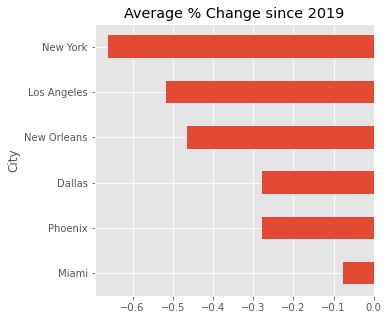

In [241]:
df_mean.plot.barh(y='column', figsize=(5, 5), xlabel = "City", ylabel = "Average % Change", title= "Average % Change since 2019")

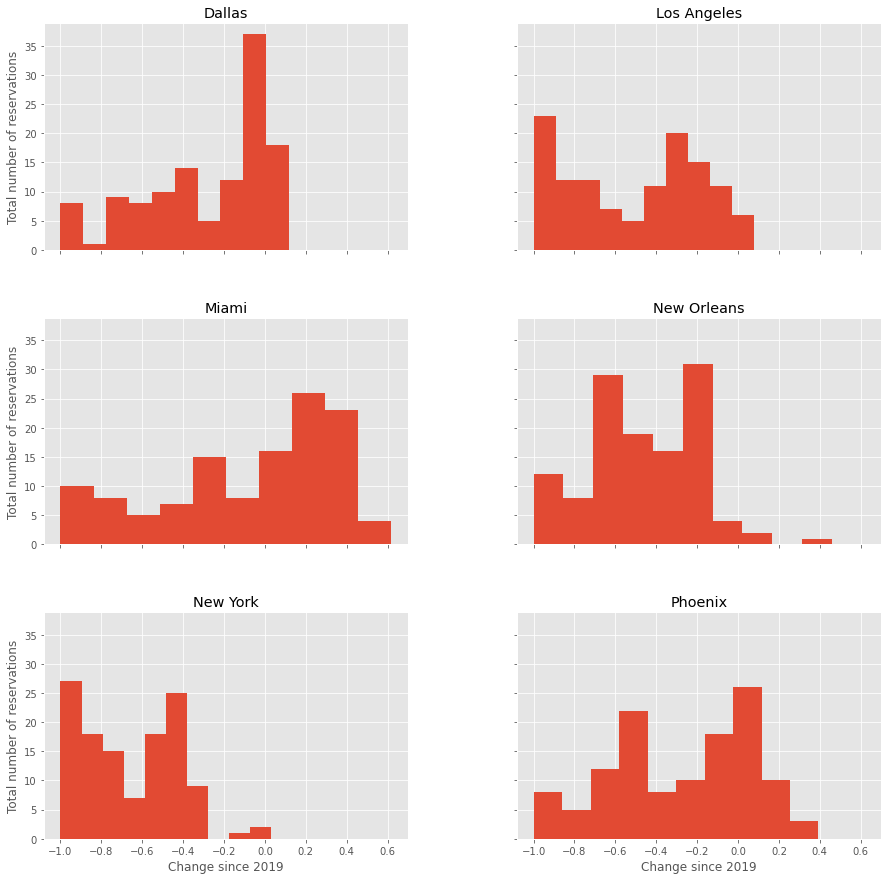

In [27]:
#showing the distribution of reservations per city
hist = df_new.hist(figsize=(15, 15), sharex=True, sharey=True)

for ax in hist.flatten():
    ax.set_xlabel("Change since 2019")
    ax.set_ylabel("Total number of reservations")
    ylabelsize =15
    xlabelsize =15
    
plt.show()

The cities that have histograms with values above 0 are cities that have (at any point) had more reservations YOY since 2019 

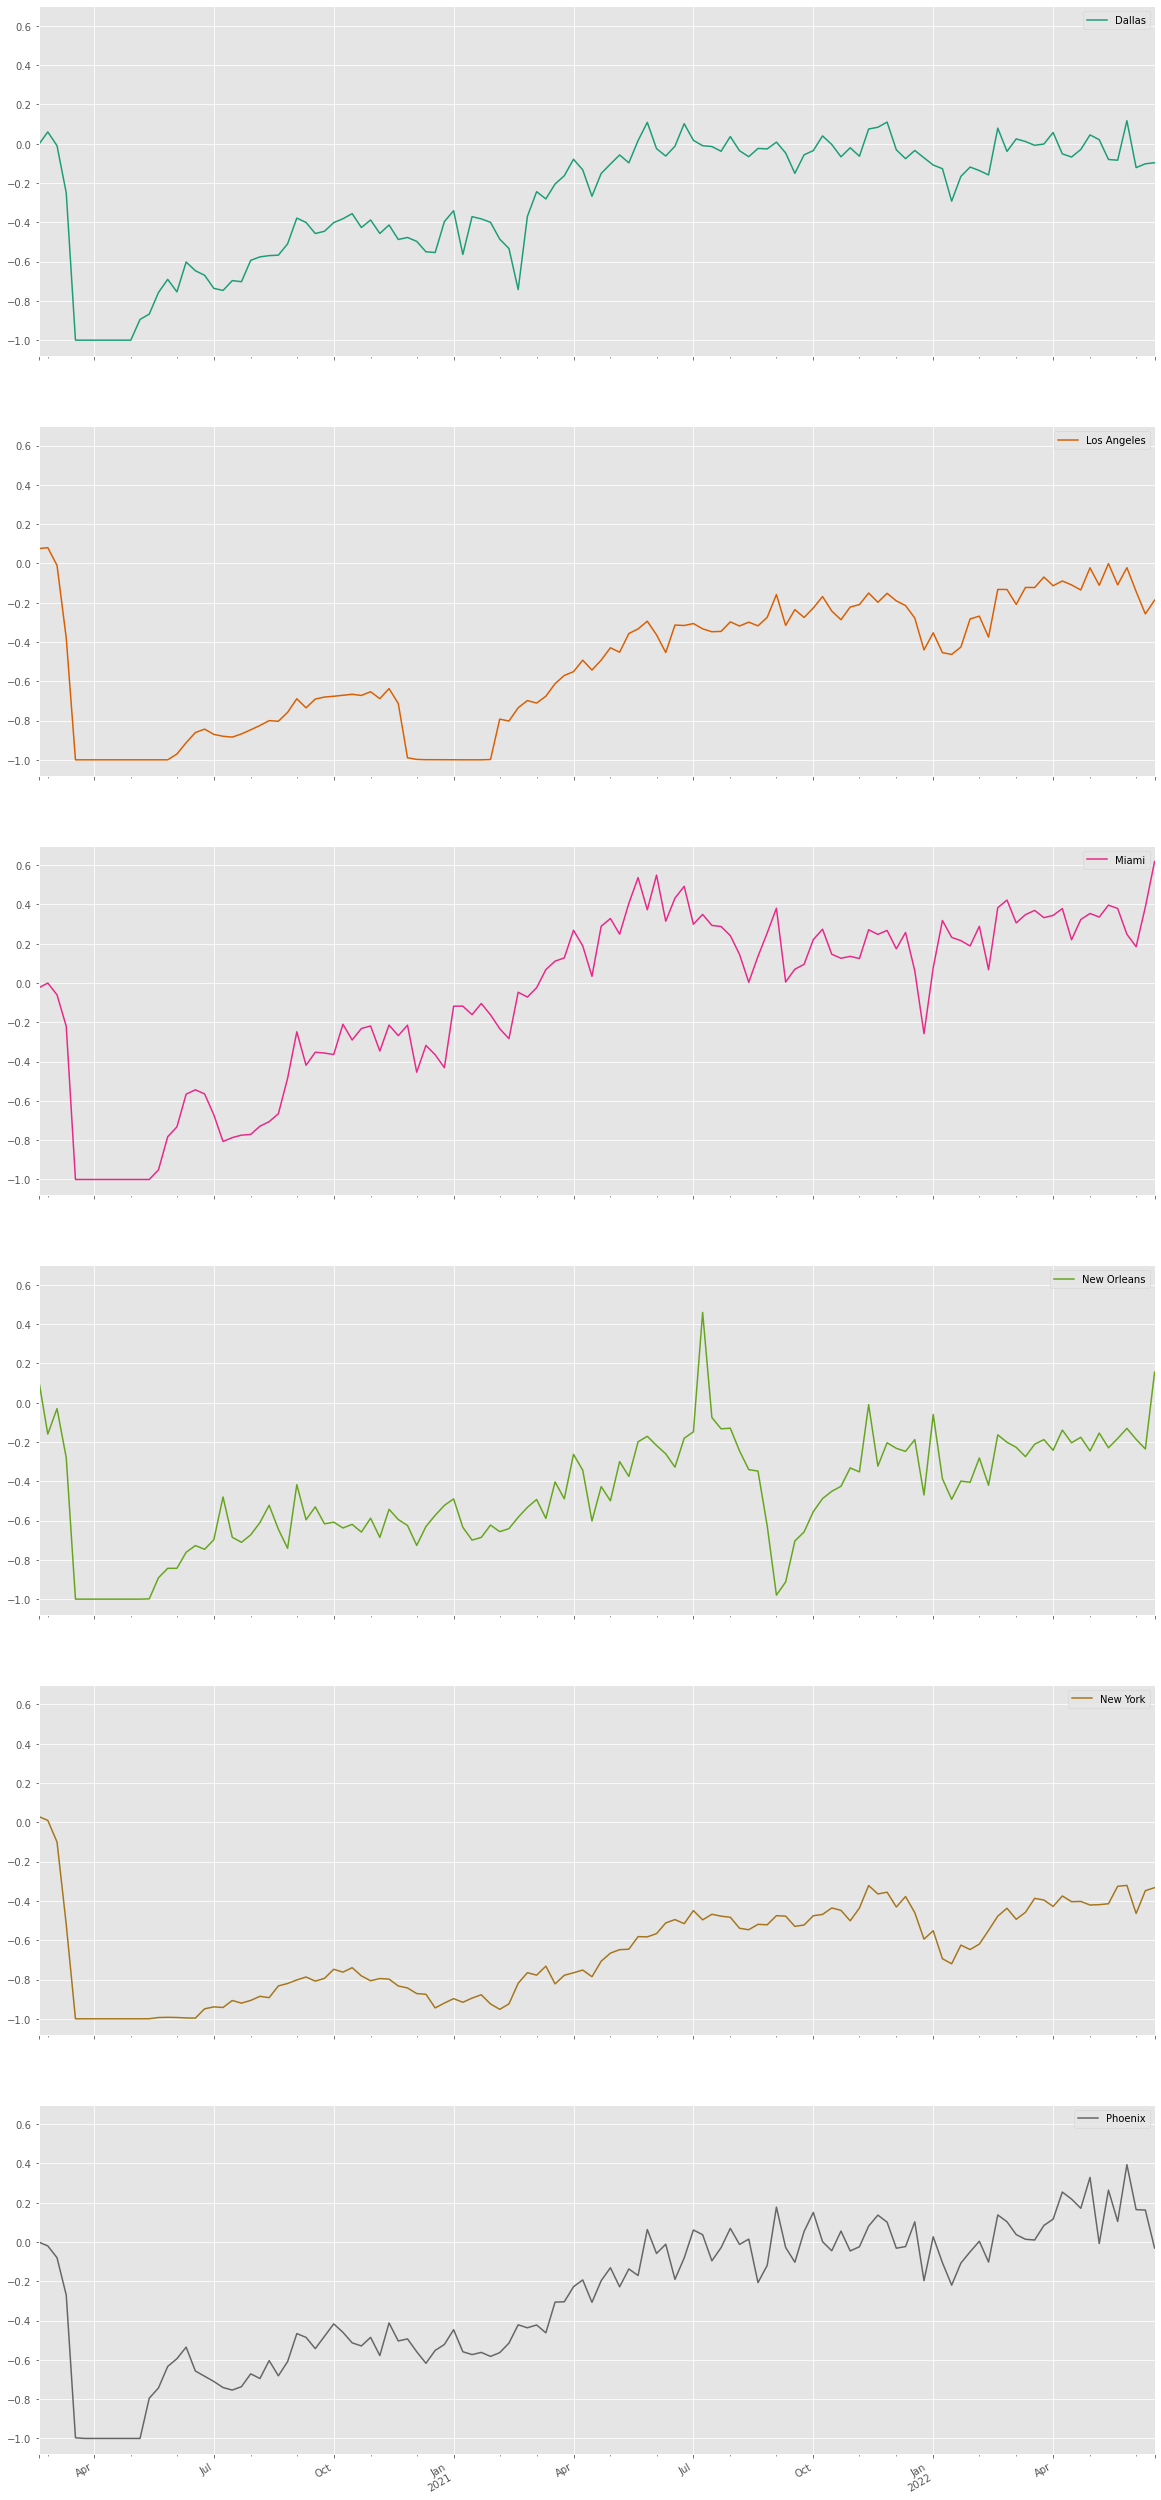

In [28]:
df_new.plot(figsize=(20, 50), colormap = 'Dark2', subplots=True, sharex=True, sharey=True)
plt.show()

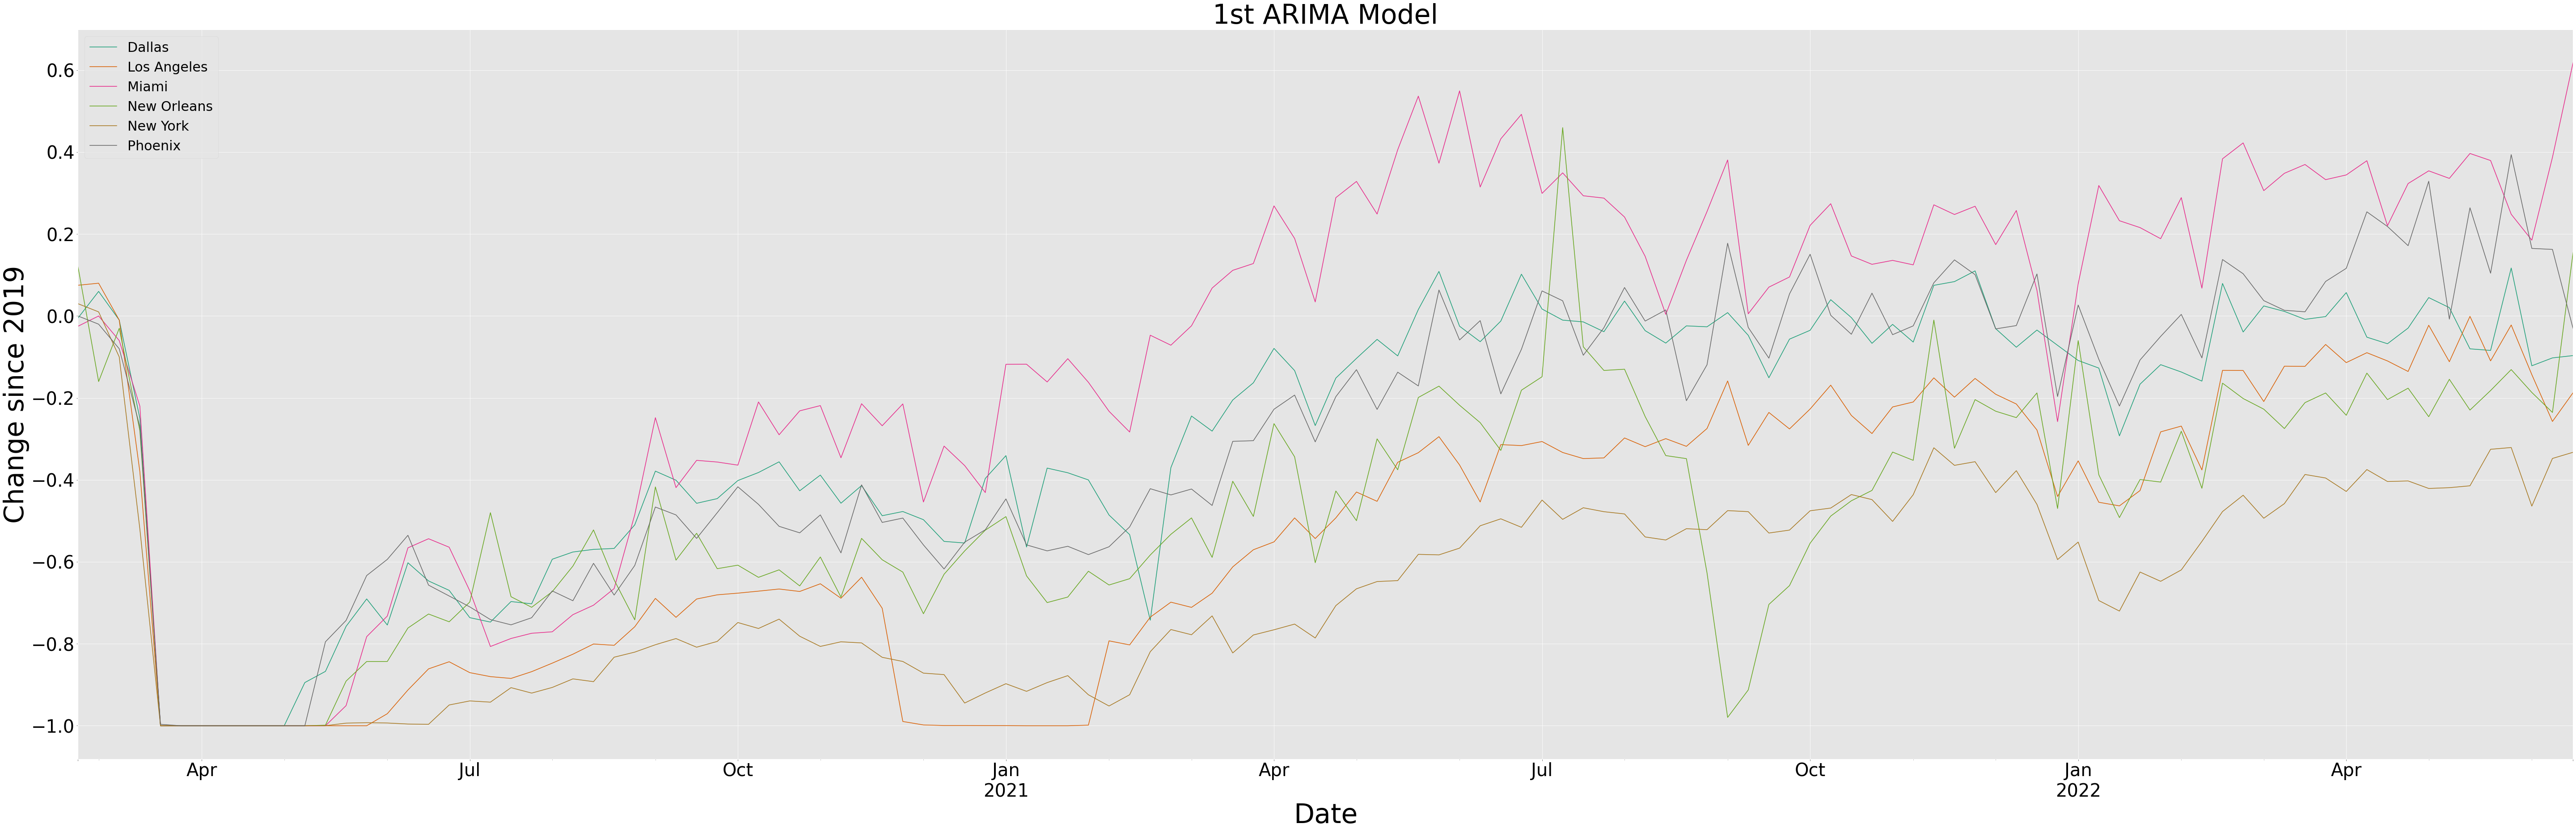

In [29]:
# Plot reservations for all cities  
df_new.plot(figsize=(100, 30), colormap = 'Dark2')
plt.xlabel("Date", fontsize=60, color = 'black')
plt.ylabel("Change since 2019",fontsize=60, color = 'black')
plt.title('1st ARIMA Model', fontsize = 60)
plt.xticks(fontsize = 40, color = 'black')
plt.yticks(fontsize = 40, color = 'black')
plt.legend(fontsize = 30, loc = 2)
plt.show()

This looks like an un-usable mess right now because there are so many data points for so many cities, but as the number of cities gets narrowed down, it will become more legible

## Test for Stationality- Dicky Fuller Test

In [30]:
adf_results = {}
for col in df_new.columns.values:  
    adf_results[col] = tsa.adfuller(df_new[col])

adf_results

{'Dallas': (-1.9783416969257674,
  0.29614949721671097,
  2,
  119,
  {'1%': -3.4865346059036564,
   '5%': -2.8861509858476264,
   '10%': -2.579896092790057},
  -220.78613108370655),
 'Los Angeles': (-2.170644907187221,
  0.217071609973847,
  1,
  120,
  {'1%': -3.486055829282407,
   '5%': -2.8859430324074076,
   '10%': -2.5797850694444446},
  -267.358127253347),
 'Miami': (-1.0975541755627176,
  0.7160462854403548,
  2,
  119,
  {'1%': -3.4865346059036564,
   '5%': -2.8861509858476264,
   '10%': -2.579896092790057},
  -142.2664546161895),
 'New Orleans': (-2.3835292798976684,
  0.14643921151576328,
  1,
  120,
  {'1%': -3.486055829282407,
   '5%': -2.8859430324074076,
   '10%': -2.5797850694444446},
  -113.40366365183559),
 'New York': (-1.9713045850533577,
  0.2992950035958716,
  3,
  118,
  {'1%': -3.4870216863700767,
   '5%': -2.8863625166643136,
   '10%': -2.580009026141913},
  -349.3399322308509),
 'Phoenix': (-1.4613825268639513,
  0.5525210857261313,
  3,
  118,
  {'1%': -3.487

In [31]:
# loop over dictionary data
non_stationary = []
stationary = []
for key, value in adf_results.items():
    if value[1] > 0.05:
        non_stationary.append(key)
    else:
        stationary.append(key)
print(f'Non-Stationary: {non_stationary}')
print(f'Stationary: {stationary}')

Non-Stationary: ['Dallas', 'Los Angeles', 'Miami', 'New Orleans', 'New York', 'Phoenix']
Stationary: []


## Separate each city into it's own dataframe

In [32]:
NY = df_new['New York']
LA = df_new['Los Angeles']
DAL = df_new['Dallas']
NOLA = df_new['New Orleans']
MIA = df_new['Miami']
PHO = df_new['Phoenix']

## Make Data Stationary

### New York

In [33]:
NY_new = NY.diff().dropna()
NY_new.head()

2020-03-01   -0.02
2020-03-08   -0.11
2020-03-15   -0.42
2020-03-22   -0.48
2020-03-29    0.00
Freq: W-SUN, Name: New York, dtype: float64

In [34]:
dftest = adfuller(NY_new)
display(dftest)

(-6.374055333155806,
 2.307064500933022e-08,
 2,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 -345.3138971617381)

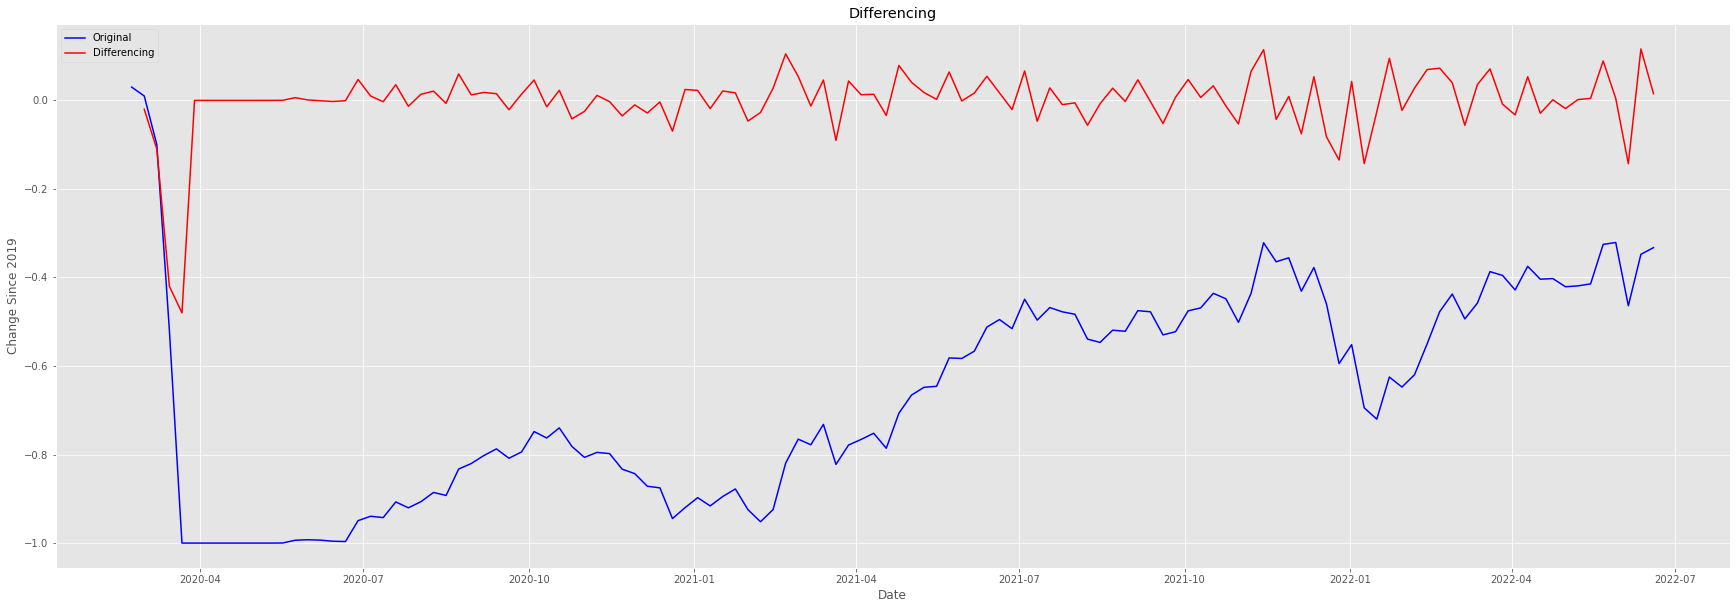

In [35]:
fig = plt.figure(figsize=(30, 10))
orig = plt.plot(NY, color='blue', label='Original')
diff = plt.plot(NY_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.title('Differencing')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.show(block=False)

### Los Angeles

In [36]:
LA_new = LA.diff().dropna()
LA_new.head()

2020-03-01    0.00
2020-03-08   -0.09
2020-03-15   -0.37
2020-03-22   -0.62
2020-03-29    0.00
Freq: W-SUN, Name: Los Angeles, dtype: float64

In [37]:
dftest = adfuller(LA_new)
display(dftest)

(-9.423753946602094,
 5.415584148724596e-16,
 0,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 -263.76600616311754)

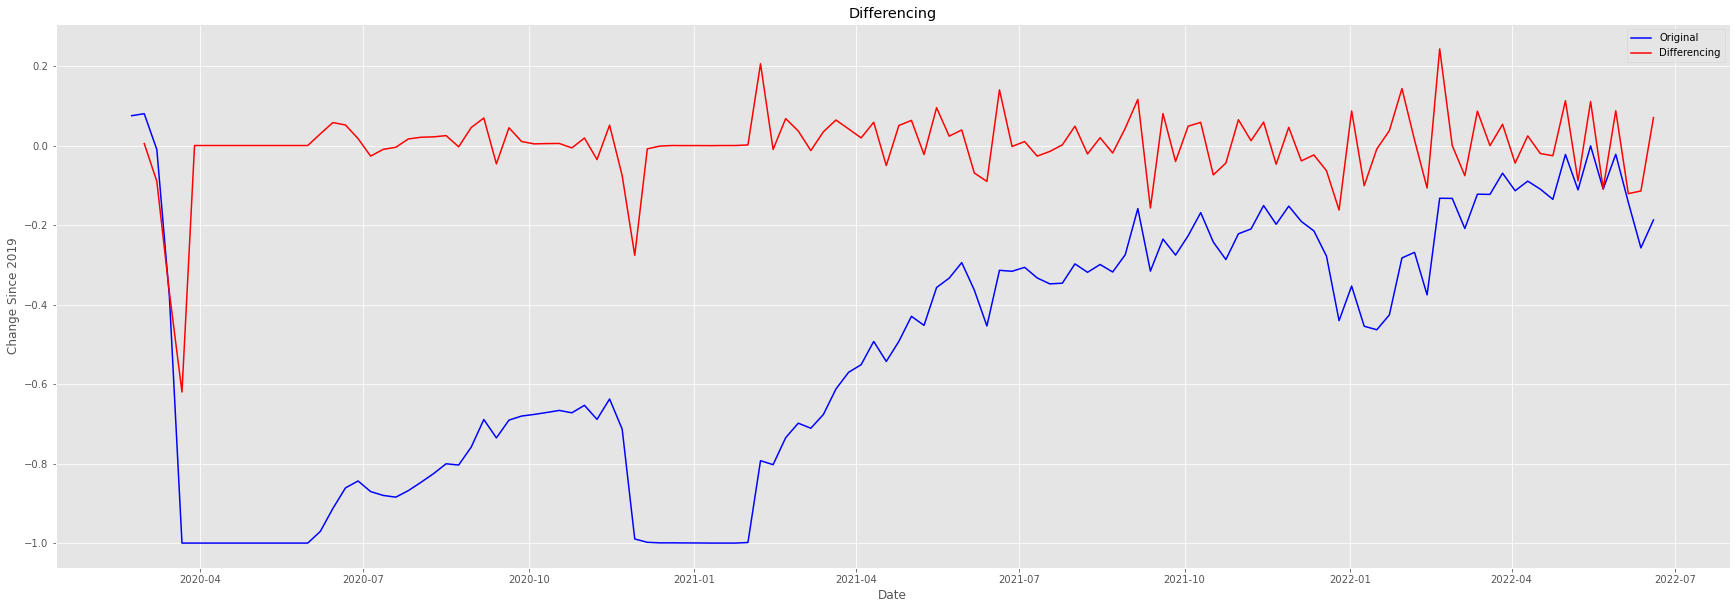

In [38]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(LA, color='blue', label='Original')
diff = plt.plot(LA_new, color='red', label='Differencing')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.legend(loc='best')
plt.title('Differencing')
plt.show(block=False)

### Dallas

In [39]:
DAL_new = DAL.diff().dropna()
DAL_new.head()

2020-03-01    0.07
2020-03-08   -0.07
2020-03-15   -0.24
2020-03-22   -0.75
2020-03-29    0.00
Freq: W-SUN, Name: Dallas, dtype: float64

In [40]:
dftest = adfuller(DAL_new)
display(dftest)

(-6.7295730795936075,
 3.322344100936657e-09,
 2,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 -216.09418213551413)

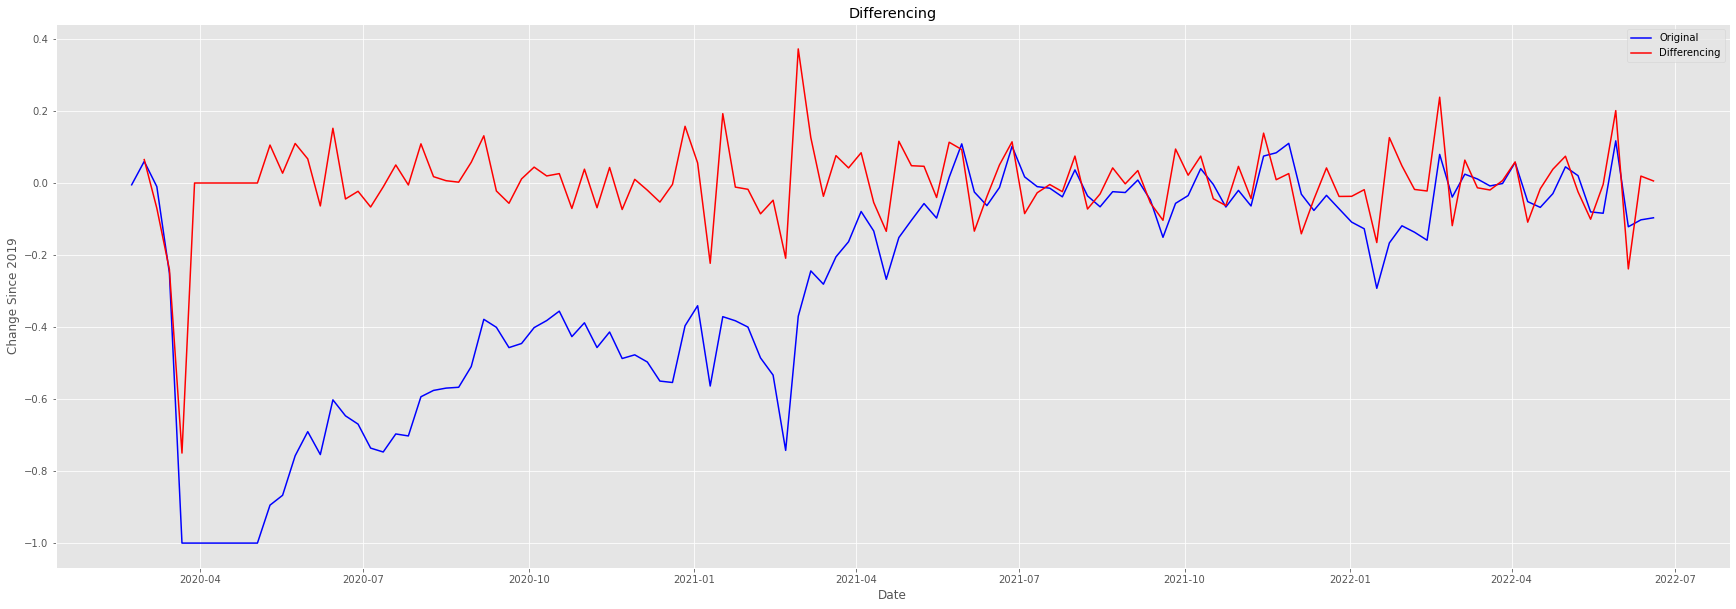

In [41]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(DAL, color='blue', label='Original')
diff = plt.plot(DAL_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

### New Orleans

In [42]:
NOLA_new = NOLA.diff().dropna()
NOLA_new.head()

2020-03-01   -0.28
2020-03-08    0.13
2020-03-15   -0.25
2020-03-22   -0.72
2020-03-29    0.00
Freq: W-SUN, Name: New Orleans, dtype: float64

In [43]:
dftest = adfuller(NOLA_new)
display(dftest)

(-14.129224607098292,
 2.349750871366758e-26,
 0,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 -107.92455198564625)

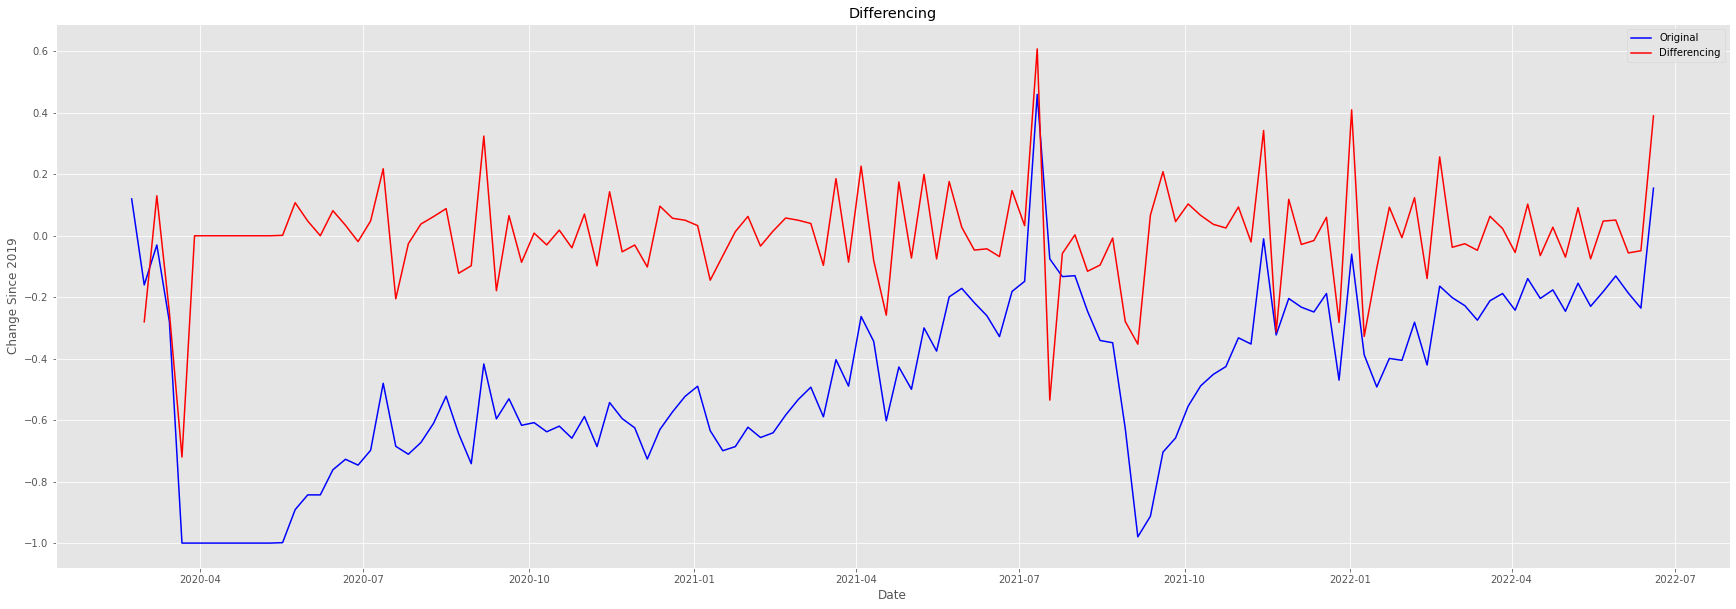

In [44]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(NOLA, color='blue', label='Original')
diff = plt.plot(NOLA_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

### Miami

In [45]:
MIA_new = MIA.diff().dropna()
MIA_new.head()

2020-03-01    0.03
2020-03-08   -0.06
2020-03-15   -0.16
2020-03-22   -0.78
2020-03-29    0.00
Freq: W-SUN, Name: Miami, dtype: float64

In [46]:
dftest = adfuller(MIA_new)
display(dftest)

(-8.745534790785477,
 2.929747173288818e-14,
 1,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 -138.70548420006122)

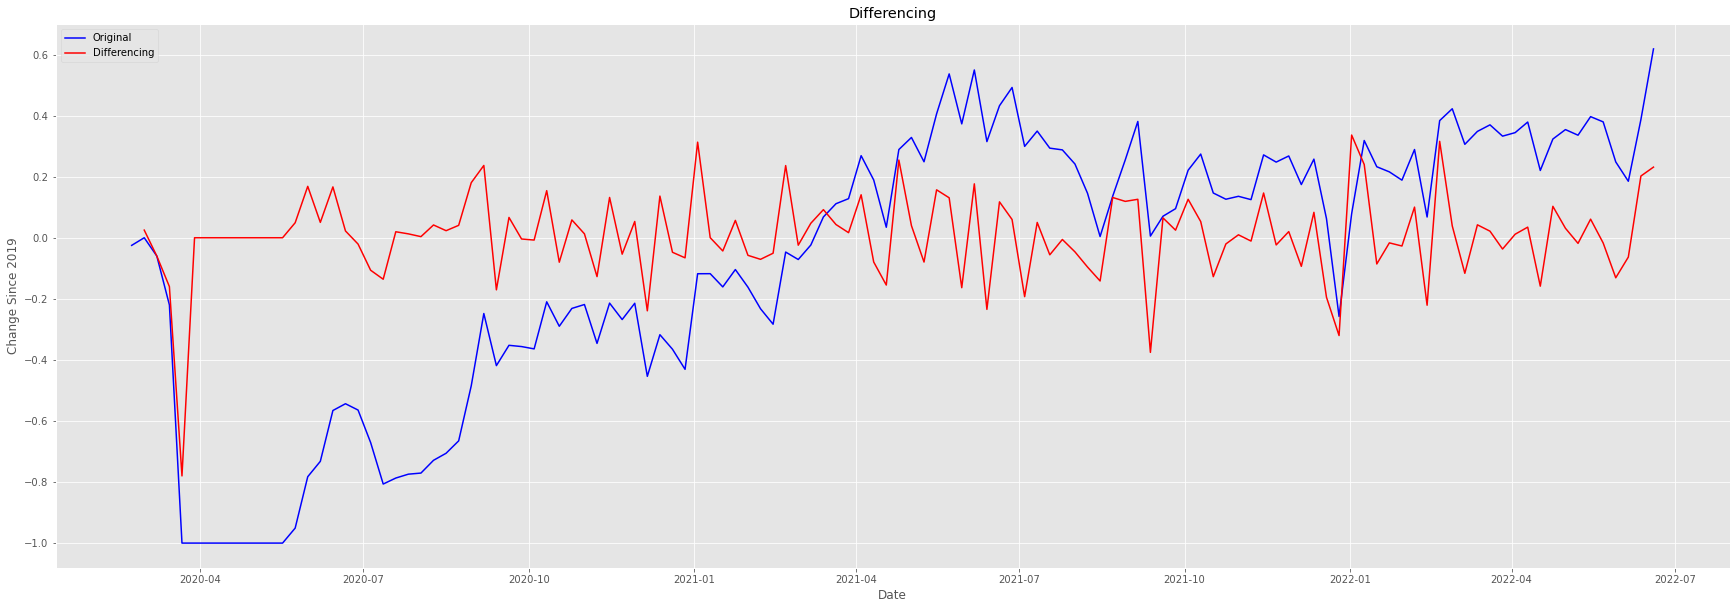

In [47]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(MIA, color='blue', label='Original')
diff = plt.plot(MIA_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

### Phoenix

In [48]:
PHO_new = PHO.diff().dropna()
PHO_new.head()

2020-03-01   -0.02
2020-03-08   -0.06
2020-03-15   -0.19
2020-03-22   -0.73
2020-03-29   -0.00
Freq: W-SUN, Name: Phoenix, dtype: float64

In [49]:
dftest = adfuller(PHO_new)
display(dftest)

(-6.866654334294502,
 1.5529309924378936e-09,
 2,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 -183.95748907123715)

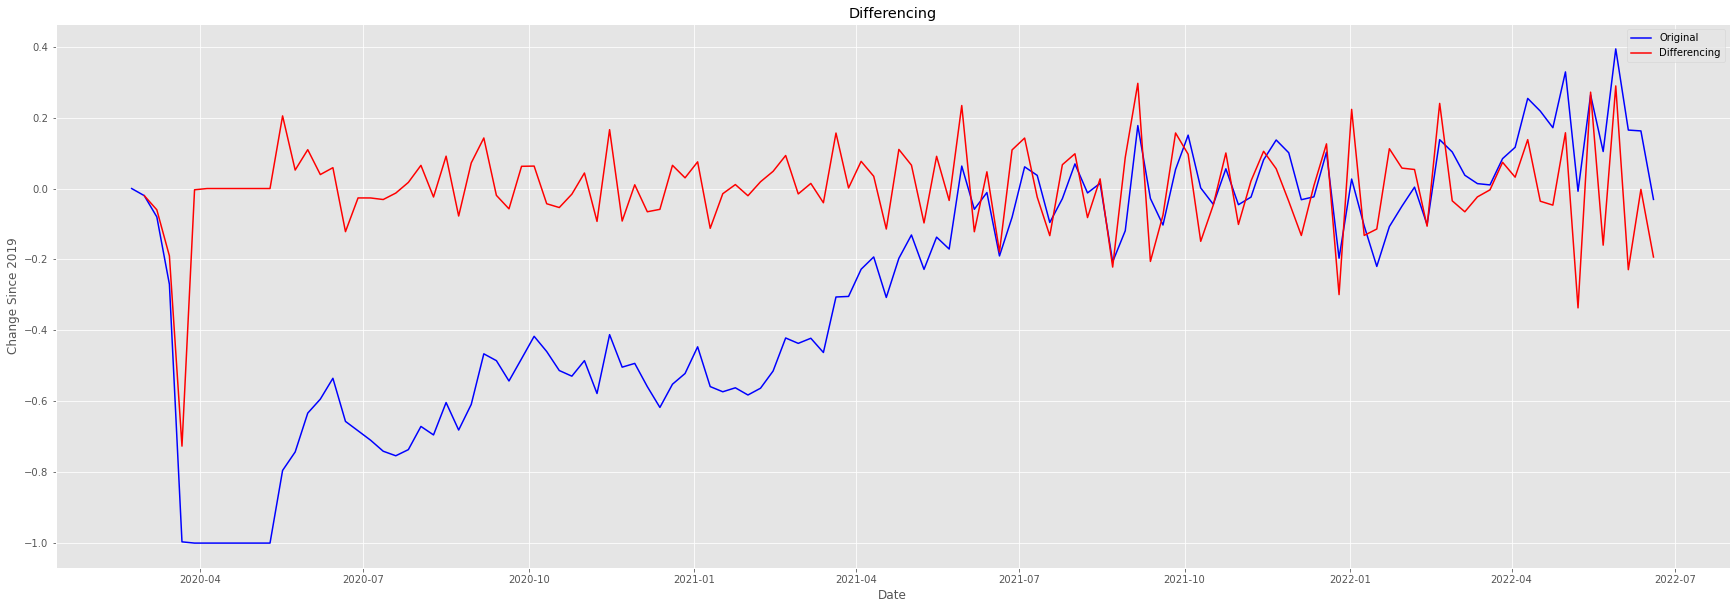

In [50]:
fig = plt.figure(figsize=(30,10))
orig = plt.plot(PHO, color='blue', label='Original')
diff = plt.plot(PHO_new, color='red', label='Differencing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.title('Differencing')
plt.show(block=False)

## New York City Modeling

In [51]:
# Find the index which allows us to split off 20% of the data
# can use the same variable "cutoff" for the other 5 cities 
# because they all have the same number of rows
cutoff = round(NY.shape[0]*0.8)
cutoff

98

In [52]:
# Define train and test sets according to the index cutoff
NY_train = NY_new[:cutoff]
NY_test = NY_new[cutoff:]

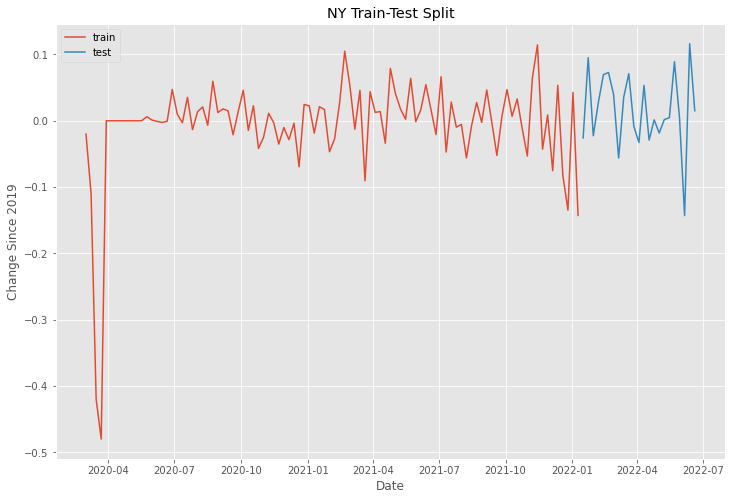

In [53]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.set_title('NY Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
plt.legend();

In [54]:
#add markdown about this ^^

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


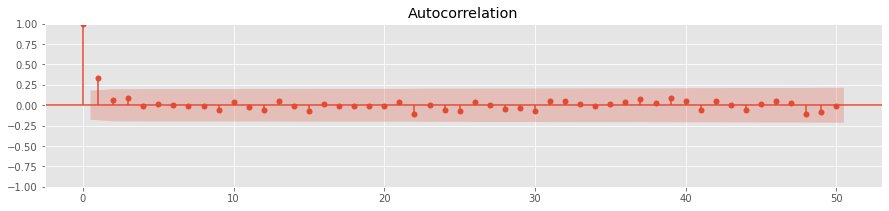

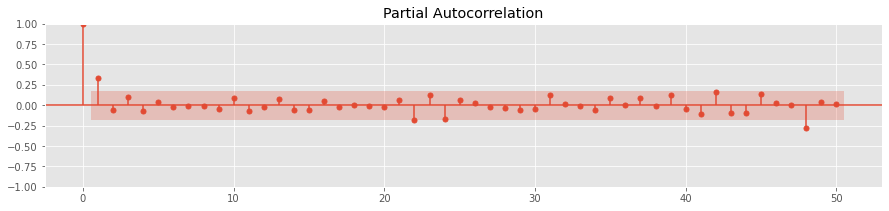

In [55]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(NY_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(NY_new, ax=ax, lags=50);

In [56]:
#Baseline Model

NY_naive = NY_train.shift(1).dropna()
NY_naive.head()

2020-03-08   -0.02
2020-03-15   -0.11
2020-03-22   -0.42
2020-03-29   -0.48
2020-04-05    0.00
Freq: W-SUN, Name: New York, dtype: float64

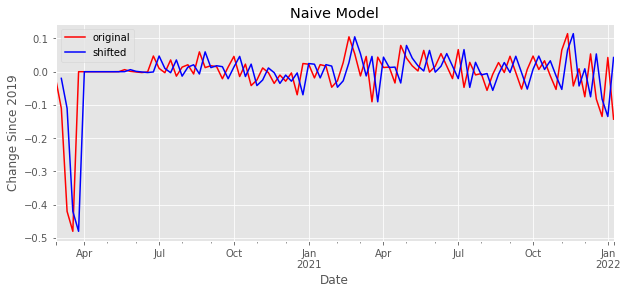

In [57]:
fig, ax = plt.subplots(figsize=(10, 4))

NY_train[0:200].plot(ax=ax, c='r', label='original')
NY_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [58]:
NY_naive_rmse = np.sqrt(mean_squared_error(NY_train[1:], NY_naive.dropna()))
NY_naive_rmse

0.08417205440208789

In [59]:
#First standard ARIMA model 
NY_AR_1 = ARIMA(NY_train, order=(0, 0, 1)).fit()  
print(NY_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:               New York   No. Observations:                   98
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 120.318
Date:                Thu, 07 Jul 2022   AIC                           -234.635
Time:                        18:48:27   BIC                           -226.880
Sample:                    03-01-2020   HQIC                          -231.499
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0081      0.014     -0.571      0.568      -0.036       0.020
ma.L1          0.4103      0.057      7.189      0.000       0.298       0.522
sigma2         0.0050      0.000     10.700      0.0

In [60]:
train_preds_1 = NY_AR_1.predict(typ='levels')
test_preds_1 = NY_AR_1.predict(start=NY_test.index[0], end=NY_test.index[-1],typ='levels')

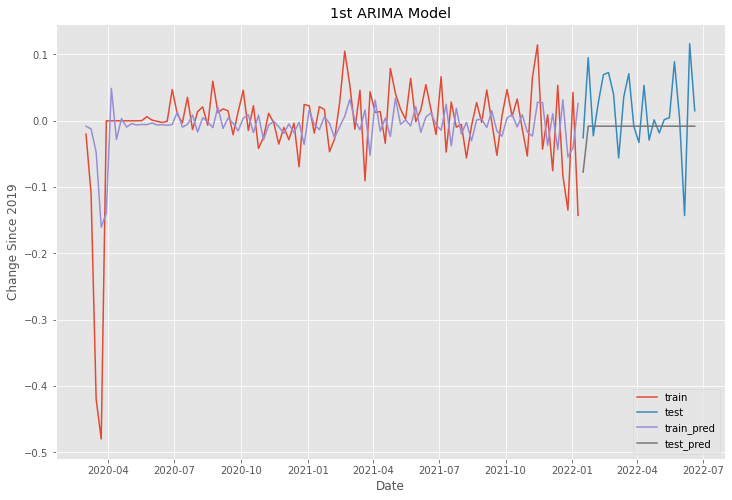

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

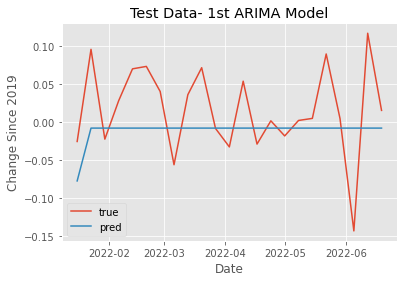

In [62]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [63]:
NY_AR_1_RMSE = np.sqrt(mean_squared_error(NY_test, test_preds_1))
NY_AR_1_RMSE

0.062337232158896694

In [64]:
#Use auto_model tool to find the optimal ARIMA model 

In [65]:
auto_model = pm.auto_arima(NY_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-234.904, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-221.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-236.590, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-235.985, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-234.834, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-233.157, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-235.084, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.268 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 120.295
Date:                Thu, 07 Jul 2022   AIC                           -236.590
Time:                        18:48:28   BIC                           -231.420
Sample:                

In [66]:
#2nd ARIMA model given the autocorrelation graph above 
NY_AR_2 = ARIMA(NY_train, order=(1,0,0)).fit()  
print(NY_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:               New York   No. Observations:                   98
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 120.542
Date:                Thu, 07 Jul 2022   AIC                           -235.084
Time:                        18:48:28   BIC                           -227.329
Sample:                    03-01-2020   HQIC                          -231.948
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.017     -0.488      0.625      -0.042       0.025
ar.L1          0.4040      0.039     10.388      0.000       0.328       0.480
sigma2         0.0050      0.000     13.212      0.0

In [67]:
train_preds_2 = NY_AR_2.predict(typ='levels')
test_preds_2 = NY_AR_2.predict(start=NY_test.index[0], end=NY_test.index[-1],typ='levels')

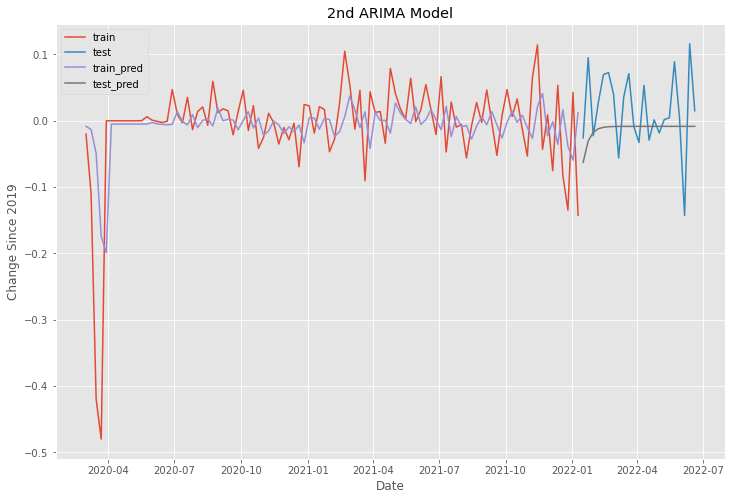

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

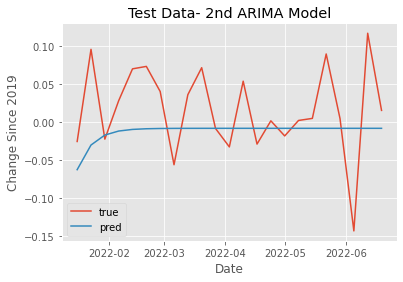

In [69]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [70]:
NY_AR_2_RMSE = np.sqrt(mean_squared_error(NY_test, test_preds_2))
NY_AR_2_RMSE

0.0638765624890895

In [71]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(NY_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-231.545, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-220.018, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-233.133, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-232.851, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-221.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-235.084, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[8] intercept   : AIC=-233.117, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[8] intercept   : AIC=-231.634, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[8] intercept   : AIC=-233.359, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-233.443, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-234.635, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[8] intercept   : AIC=-231.683, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[8]             : AIC=-236.590, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8]             : AIC=-234.613, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[8]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 120.295
Date:                Thu, 07 Jul 2022   AIC                           -236.590
Time:                        18:48:29   BIC                           -231.420
Sample:                             0   HQIC                          -234.498
                                 - 98                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4090      0.034     11.962      0.000       0.342       0.476
sigma2         0.0050      0.000     15.055      0.000       0.004       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               443.55
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -2.07
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
NY_SARIMA =SARIMAX(NY_train,
                  order=(1,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(NY_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:               New York   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 118.694
Date:                Thu, 07 Jul 2022   AIC                           -233.388
Time:                        18:48:29   BIC                           -228.239
Sample:                    03-01-2020   HQIC                          -231.306
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4131      0.034     12.033      0.000       0.346       0.480
sigma2         0.0051      0.000     14.938      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.02   Jarque-

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [73]:
train_preds_3 = NY_SARIMA.predict(typ='levels')
test_preds_3 = NY_SARIMA.predict(start=NY_test.index[0], end=NY_test.index[-1],typ='levels')

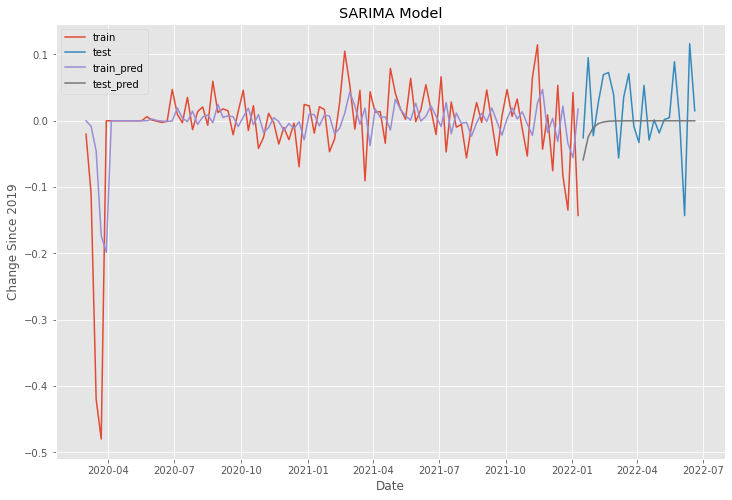

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NY_train, label='train')
ax.plot(NY_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

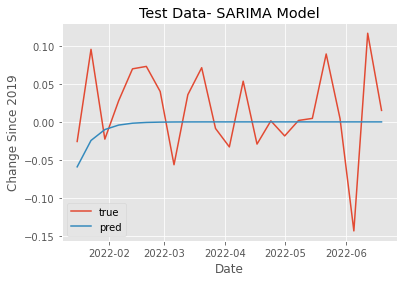

In [75]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [76]:
NY_SARIMA_RMSE = np.sqrt(mean_squared_error(NY_test, test_preds_3))
NY_SARIMA_RMSE

0.06098265529888748

In [77]:
#compiled test scores

In [78]:
print(f'AR_1 AIC: {NY_AR_1.aic}' )
print(f'AR_2 AIC: {NY_AR_2.aic}' )
print(f'SMODEL AIC: {NY_SARIMA.aic}' )

AR_1 AIC: -234.6352227115253
AR_2 AIC: -235.0842267339931
SMODEL AIC: -233.38839248865904


In [79]:
print(f'Naive RMSE: {NY_naive_rmse}')
print(f'AR_1 RMSE: {NY_AR_1_RMSE}' )
print(f'AR_2 RMSE: {NY_AR_2_RMSE}' )
print(f'SMODEL RMSE: {NY_SARIMA_RMSE}' )

Naive RMSE: 0.08417205440208789
AR_1 RMSE: 0.062337232158896694
AR_2 RMSE: 0.0638765624890895
SMODEL RMSE: 0.06098265529888748


In [80]:
#final model- SARIMA

In [81]:
#Forecast Error
forecast_error = (NY_test- test_preds_3)
forecast_error

2022-01-16    0.03
2022-01-23    0.12
2022-01-30   -0.01
2022-02-06    0.03
2022-02-13    0.07
2022-02-20    0.07
2022-02-27    0.04
2022-03-06   -0.06
2022-03-13    0.04
2022-03-20    0.07
2022-03-27   -0.01
2022-04-03   -0.03
2022-04-10    0.05
2022-04-17   -0.03
2022-04-24    0.00
2022-05-01   -0.02
2022-05-08    0.00
2022-05-15    0.00
2022-05-22    0.09
2022-05-29    0.00
2022-06-05   -0.14
2022-06-12    0.12
2022-06-19    0.02
Freq: W-SUN, dtype: float64

In [82]:
#Mean Forecast Error
mean_forecast_error = (NY_test - test_preds_3).mean()
mean_forecast_error

0.020096768653006768

In [83]:
df_forecast=pd.concat([NY_test, test_preds_3, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-16      -0.03           -0.06        0.03
2022-01-23       0.10           -0.02        0.12
2022-01-30      -0.02           -0.01       -0.01
2022-02-06       0.03           -0.00        0.03
2022-02-13       0.07           -0.00        0.07
2022-02-20       0.07           -0.00        0.07
2022-02-27       0.04           -0.00        0.04
2022-03-06      -0.06           -0.00       -0.06
2022-03-13       0.04           -0.00        0.04
2022-03-20       0.07           -0.00        0.07
2022-03-27      -0.01           -0.00       -0.01
2022-04-03      -0.03           -0.00       -0.03
2022-04-10       0.05           -0.00        0.05
2022-04-17      -0.03           -0.00       -0.03
2022-04-24       0.00           -0.00        0.00
2022-05-01      -0.02           -0.00       -0.02
2022-05-08       0.00           -0.00        0.00
2022-05-15       0.00           -0.00        0.00
2022-05-22       0.09           -0.00        0.09
2022-05-29       0.00           -0.00        0.00
2022-06-05      -0.14           -0.00       -0.14
2022-06-12       0.12           -0.00        0.12
2022-06-19       0.02           -0.00        0.02

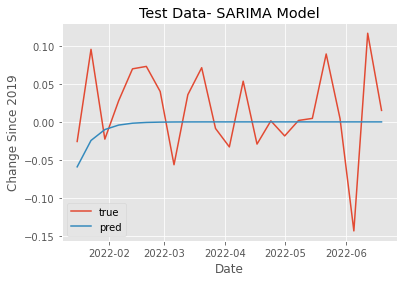

In [84]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NY_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

## Los Angeles Modeling

In [85]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
LA_train = LA_new[:cutoff]
LA_test = LA_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


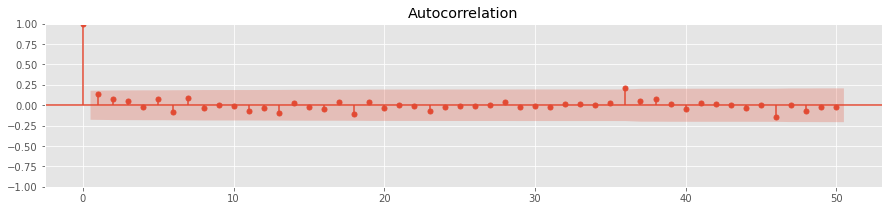

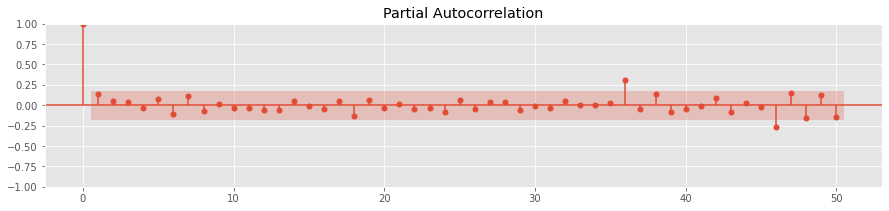

In [86]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(LA_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(LA_new, ax=ax, lags=50);

In [87]:
#Baseline Model

LA_naive = LA_train.shift(1).dropna()
LA_naive.head()

2020-03-08    0.00
2020-03-15   -0.09
2020-03-22   -0.37
2020-03-29   -0.62
2020-04-05    0.00
Freq: W-SUN, Name: Los Angeles, dtype: float64

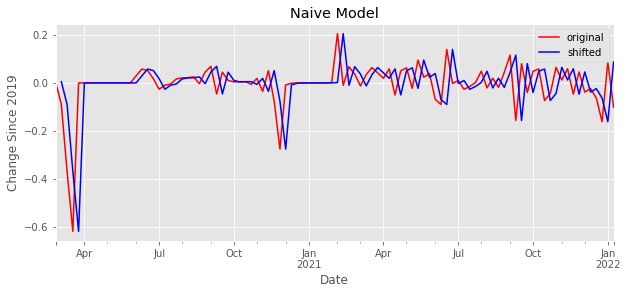

In [88]:
fig, ax = plt.subplots(figsize=(10, 4))

LA_train[0:200].plot(ax=ax, c='r', label='original')
LA_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [89]:
LA_naive_rmse = np.sqrt(mean_squared_error(LA_train[1:], LA_naive.dropna()))
LA_naive_rmse

0.11529537816757496

In [90]:
#First standard ARIMA model 
LA_AR_1 = ARIMA(LA_train, order=(0, 0, 1)).fit()  
print(LA_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:            Los Angeles   No. Observations:                   98
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  95.244
Date:                Thu, 07 Jul 2022   AIC                           -184.487
Time:                        18:48:30   BIC                           -176.732
Sample:                    03-01-2020   HQIC                          -181.351
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.016     -0.351      0.726      -0.037       0.026
ma.L1          0.2410      0.082      2.924      0.003       0.079       0.403
sigma2         0.0084      0.001      9.536      0.0

In [91]:
train_preds_1 = LA_AR_1.predict(typ='levels')
test_preds_1 = LA_AR_1.predict(start=LA_test.index[0], end=LA_test.index[-1],typ='levels')

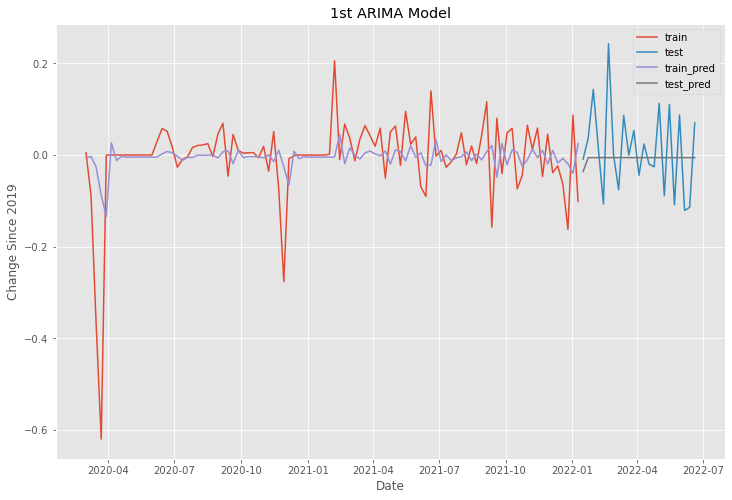

In [92]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

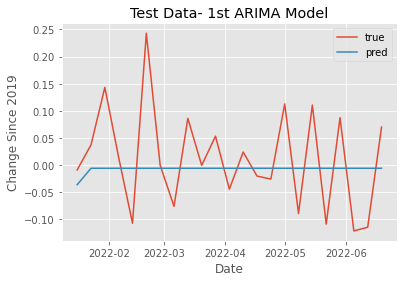

In [93]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [94]:
LA_AR_1_RMSE = np.sqrt(mean_squared_error(LA_test, test_preds_1))
LA_AR_1_RMSE

0.09368120199551734

In [95]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(LA_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-184.916, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-182.010, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-186.857, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-186.243, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-184.914, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-182.918, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-185.068, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.233 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  95.428
Date:                Thu, 07 Jul 2022   AIC                           -186.857
Time:                        18:48:30   BIC                           -181.687
Sample:                

In [96]:
#2nd ARIMA model given the autocorrelation graph above 
LA_AR_2 = ARIMA(LA_train, order=(1,0,0)).fit()  
print(LA_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:            Los Angeles   No. Observations:                   98
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  95.534
Date:                Thu, 07 Jul 2022   AIC                           -185.068
Time:                        18:48:30   BIC                           -177.313
Sample:                    03-01-2020   HQIC                          -181.932
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.017     -0.328      0.743      -0.040       0.028
ar.L1          0.2578      0.060      4.297      0.000       0.140       0.375
sigma2         0.0083      0.001     10.976      0.0

In [97]:
train_preds_2 = LA_AR_2.predict(typ='levels')
test_preds_2 = LA_AR_2.predict(start=LA_test.index[0], end=LA_test.index[-1],typ='levels')

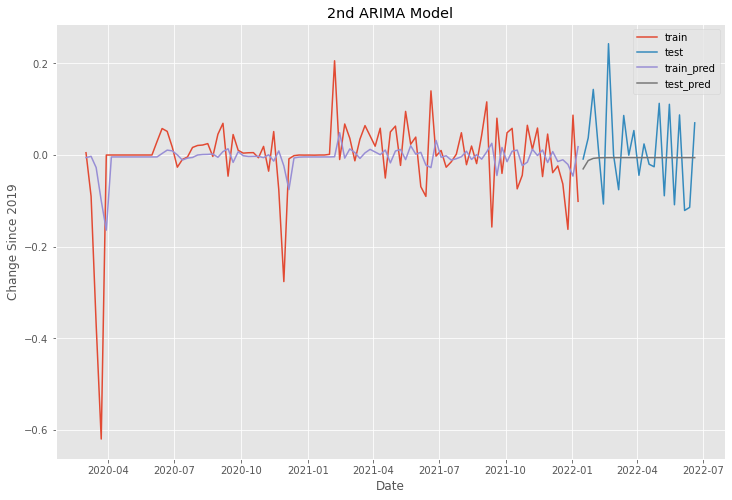

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

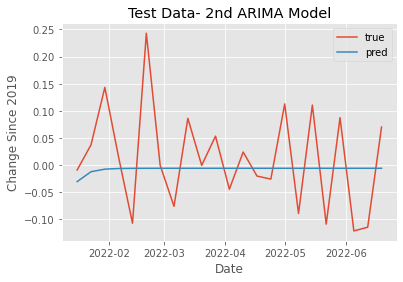

In [99]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [100]:
LA_AR_2_RMSE = np.sqrt(mean_squared_error(LA_test, test_preds_2))
LA_AR_2_RMSE

0.09387438406291769

In [101]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(LA_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-181.277, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-180.330, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-183.194, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-182.596, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-182.010, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-185.068, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[8] intercept   : AIC=-183.214, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[8] intercept   : AIC=-181.226, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[8] intercept   : AIC=-183.118, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-183.121, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-184.487, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[8] intercept   : AIC=-181.125, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[8]             : AIC=-186.857, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8]             : AIC=-184.951, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[8]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  95.428
Date:                Thu, 07 Jul 2022   AIC                           -186.857
Time:                        18:48:32   BIC                           -181.687
Sample:                             0   HQIC                          -184.765
                                 - 98                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2599      0.058      4.484      0.000       0.146       0.374
sigma2         0.0083      0.001     11.644      0.000       0.007       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               619.67
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -2.44
Prob(H) (two-sided):                  0.03   Kurtosis:                        14.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
LA_SARIMA =SARIMAX(LA_train,
                  order=(1,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(LA_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:            Los Angeles   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  93.993
Date:                Thu, 07 Jul 2022   AIC                           -183.987
Time:                        18:48:32   BIC                           -178.838
Sample:                    03-01-2020   HQIC                          -181.905
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2626      0.058      4.520      0.000       0.149       0.376
sigma2         0.0084      0.001     11.569      0.000       0.007       0.010
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [103]:
train_preds_3 = LA_SARIMA.predict(typ='levels')
test_preds_3 = LA_SARIMA.predict(start=LA_test.index[0], end=LA_test.index[-1],typ='levels')

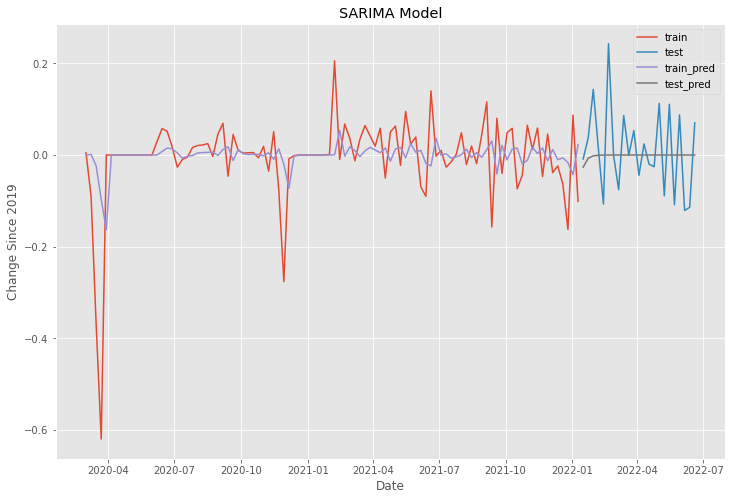

In [104]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

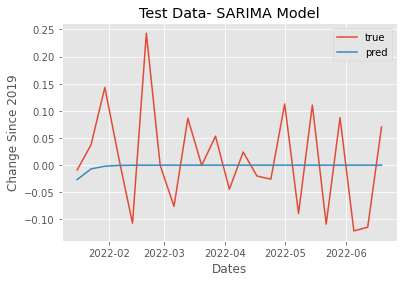

In [105]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Dates')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [106]:
LA_SARIMA_RMSE = np.sqrt(mean_squared_error(LA_test, test_preds_3))
LA_SARIMA_RMSE

0.09294276694873878

In [107]:
#compiled test scores

In [108]:
print(f'AR_1 AIC: {LA_AR_1.aic}' )
print(f'AR_2 AIC: {LA_AR_2.aic}' )
print(f'SMODEL AIC: {LA_SARIMA.aic}' )

AR_1 AIC: -184.48729461990425
AR_2 AIC: -185.06834577869145
SMODEL AIC: -183.98694272951448


In [109]:
print(f'Naive RMSE: {LA_naive_rmse}')
print(f'AR_1 RMSE: {LA_AR_1_RMSE}' )
print(f'AR_2 RMSE: {LA_AR_2_RMSE}' )
print(f'SMODEL RMSE: {LA_SARIMA_RMSE}' )

Naive RMSE: 0.11529537816757496
AR_1 RMSE: 0.09368120199551734
AR_2 RMSE: 0.09387438406291769
SMODEL RMSE: 0.09294276694873878


In [110]:
#final model- SARIMA

In [111]:
#Forecast Error
forecast_error = (LA_test- test_preds_3)
forecast_error

2022-01-16    0.02
2022-01-23    0.04
2022-01-30    0.15
2022-02-06    0.01
2022-02-13   -0.11
2022-02-20    0.24
2022-02-27   -0.00
2022-03-06   -0.08
2022-03-13    0.09
2022-03-20   -0.00
2022-03-27    0.05
2022-04-03   -0.04
2022-04-10    0.02
2022-04-17   -0.02
2022-04-24   -0.03
2022-05-01    0.11
2022-05-08   -0.09
2022-05-15    0.11
2022-05-22   -0.11
2022-05-29    0.09
2022-06-05   -0.12
2022-06-12   -0.11
2022-06-19    0.07
Freq: W-SUN, dtype: float64

In [112]:
#Mean Forecast Error
mean_forecast_error = (LA_test - test_preds_3).mean()
mean_forecast_error

0.013191403214304448

In [113]:
df_forecast=pd.concat([LA_test, test_preds_3, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-16      -0.01           -0.03        0.02
2022-01-23       0.04           -0.01        0.04
2022-01-30       0.14           -0.00        0.15
2022-02-06       0.01           -0.00        0.01
2022-02-13      -0.11           -0.00       -0.11
2022-02-20       0.24           -0.00        0.24
2022-02-27      -0.00           -0.00       -0.00
2022-03-06      -0.08           -0.00       -0.08
2022-03-13       0.09           -0.00        0.09
2022-03-20      -0.00           -0.00       -0.00
2022-03-27       0.05           -0.00        0.05
2022-04-03      -0.04           -0.00       -0.04
2022-04-10       0.02           -0.00        0.02
2022-04-17      -0.02           -0.00       -0.02
2022-04-24      -0.03           -0.00       -0.03
2022-05-01       0.11           -0.00        0.11
2022-05-08      -0.09           -0.00       -0.09
2022-05-15       0.11           -0.00        0.11
2022-05-22      -0.11           -0.00       -0.11
2022-05-29       0.09           -0.00        0.09
2022-06-05      -0.12           -0.00       -0.12
2022-06-12      -0.11           -0.00       -0.11
2022-06-19       0.07           -0.00        0.07

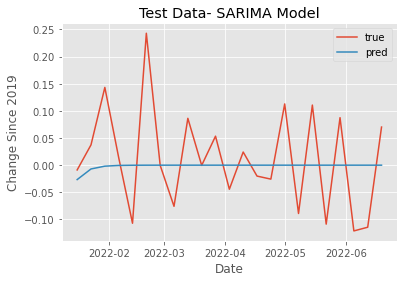

In [114]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(LA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

## Dallas Modeling

In [115]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
DAL_train = DAL_new[:cutoff]
DAL_test = DAL_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


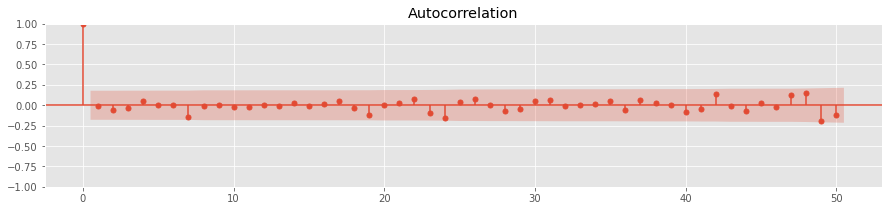

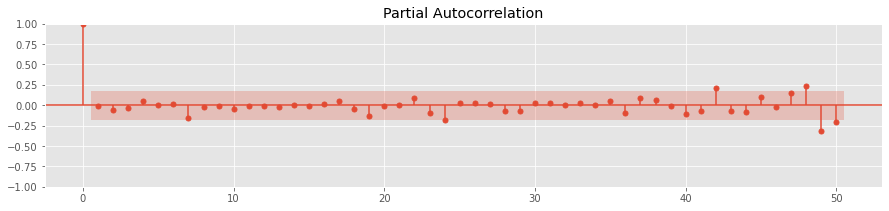

In [116]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(DAL_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(DAL_new, ax=ax, lags=50);

In [117]:
#Baseline Model

DAL_naive = DAL_train.shift(1).dropna()
DAL_naive.head()

2020-03-08    0.07
2020-03-15   -0.07
2020-03-22   -0.24
2020-03-29   -0.75
2020-04-05    0.00
Freq: W-SUN, Name: Dallas, dtype: float64

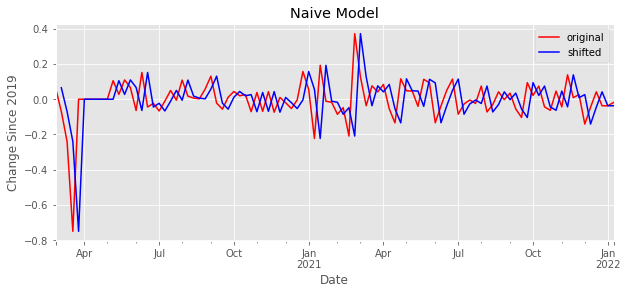

In [118]:
fig, ax = plt.subplots(figsize=(10, 4))

DAL_train[0:200].plot(ax=ax, c='r', label='original')
DAL_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [119]:
DAL_naive_rmse = np.sqrt(mean_squared_error(DAL_train[1:], DAL_naive.dropna()))
DAL_naive_rmse

0.1578980282321082

In [120]:
#First standard ARIMA model 
DAL_AR_1 = ARIMA(DAL_train, order=(0, 0, 1)).fit()  
print(DAL_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 Dallas   No. Observations:                   98
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  73.004
Date:                Thu, 07 Jul 2022   AIC                           -140.007
Time:                        18:48:33   BIC                           -132.252
Sample:                    03-01-2020   HQIC                          -136.871
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.018     -0.068      0.946      -0.036       0.034
ma.L1          0.0740      0.105      0.706      0.480      -0.132       0.280
sigma2         0.0132      0.001     15.464      0.0

In [121]:
train_preds_1 = DAL_AR_1.predict(typ='levels')
test_preds_1 = DAL_AR_1.predict(start=DAL_test.index[0], end=DAL_test.index[-1],typ='levels')

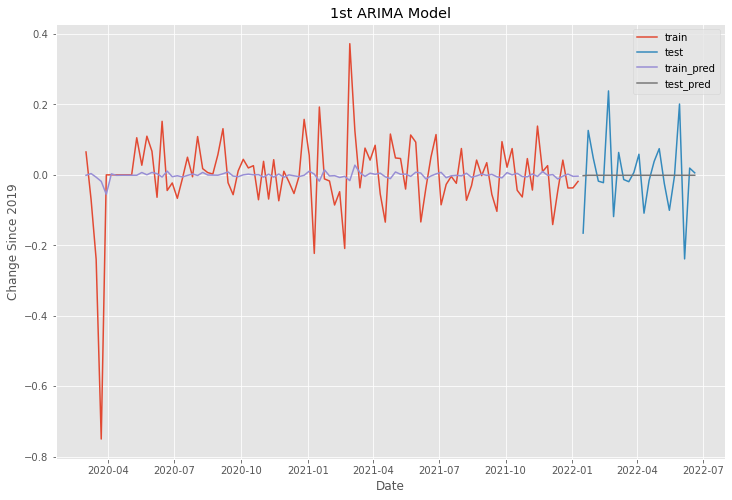

In [122]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

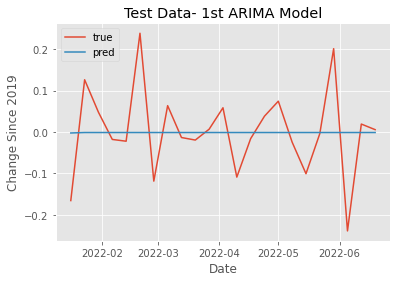

In [123]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [124]:
DAL_AR_1_RMSE = np.sqrt(mean_squared_error(DAL_test, test_preds_1))
DAL_AR_1_RMSE

0.10479293762366862

In [125]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(DAL_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-140.054, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-143.499, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-141.952, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-141.998, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-141.511, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.134 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  72.750
Date:                Thu, 07 Jul 2022   AIC                           -143.499
Time:                        18:48:33   BIC                           -140.914
Sample:                             0   HQIC                          -142.454
                                 - 98                                       

In [126]:
#2nd ARIMA model given the autocorrelation graph above 
DAL_AR_2 = ARIMA(DAL_train, order=(0,0,0)).fit()  
print(DAL_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:                 Dallas   No. Observations:                   98
Model:                          ARIMA   Log Likelihood                  72.755
Date:                Thu, 07 Jul 2022   AIC                           -141.511
Time:                        18:48:33   BIC                           -136.341
Sample:                    03-01-2020   HQIC                          -139.419
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.014     -0.088      0.930      -0.029       0.027
sigma2         0.0133      0.001     17.701      0.000       0.012       0.015
Ljung-Box (L1) (Q):                   0.47   Jarque-

In [127]:
train_preds_2 = DAL_AR_2.predict(typ='levels')
test_preds_2 = DAL_AR_2.predict(start=DAL_test.index[0], end=DAL_test.index[-1],typ='levels')

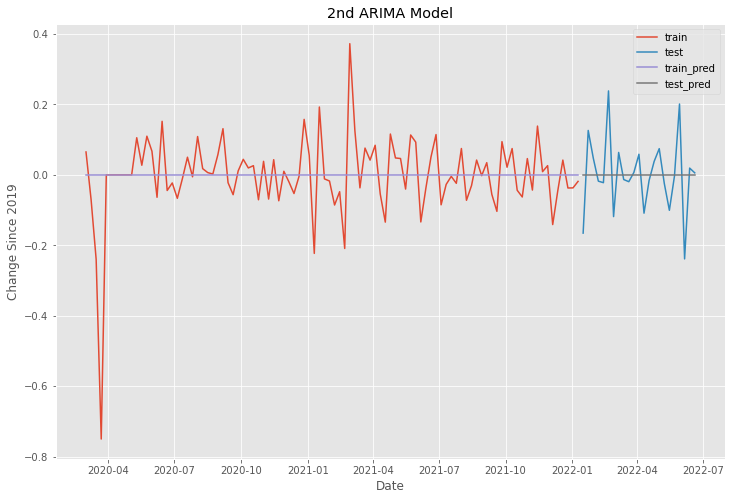

In [128]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

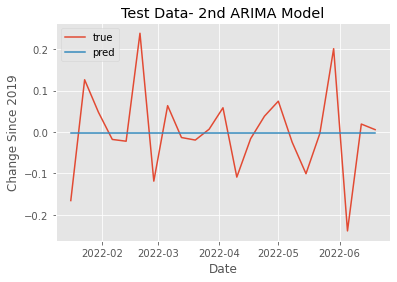

In [129]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [130]:
DAL_AR_2_RMSE = np.sqrt(mean_squared_error(DAL_test, test_preds_2))
DAL_AR_2_RMSE

0.10486863509491355

In [131]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(DAL_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-136.232, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-141.511, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-138.118, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-138.159, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-143.499, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[8] intercept   : AIC=-139.740, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[8] intercept   : AIC=-139.731, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-139.641, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-139.962, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-140.007, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-138.064, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[8]          
Total fit time: 0.561 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  72.750
Date:                Thu, 07 Jul 2022   AIC                           -143.499
Time:                        18:48:34   BIC                           -140.914
Sample:                             0   HQIC                          -142.454
                                 - 98                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0133      0.001     21.729      0.000       0.012       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):              1307.57
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -2.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
DAL_SARIMA =SARIMAX(DAL_train,
                  order=(0,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(DAL_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                 Dallas   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  71.668
Date:                Thu, 07 Jul 2022   AIC                           -141.335
Time:                        18:48:34   BIC                           -138.761
Sample:                    03-01-2020   HQIC                          -140.294
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0134      0.001     21.576      0.000       0.012       0.015
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1275.03
Prob(Q):                              0.47   Pr

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [133]:
train_preds_3 = DAL_SARIMA.predict(typ='levels')
test_preds_3 = DAL_SARIMA.predict(start=DAL_test.index[0], end=DAL_test.index[-1],typ='levels')

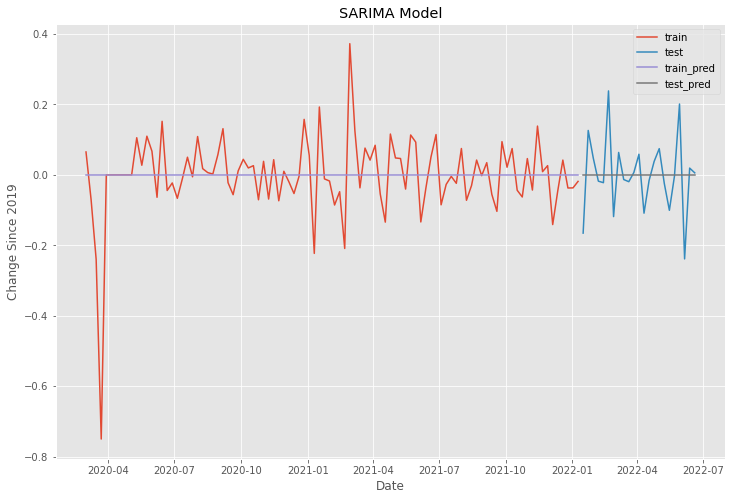

In [134]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

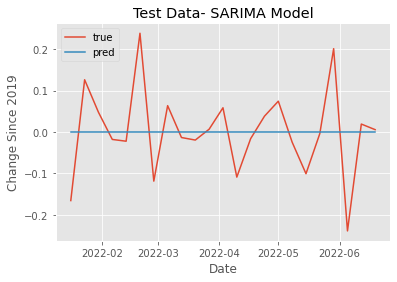

In [135]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [136]:
DAL_SARIMA_RMSE = np.sqrt(mean_squared_error(DAL_test, test_preds_3))
DAL_SARIMA_RMSE

0.104845354026154

In [137]:
#compiled test scores

In [138]:
print(f'AR_1 AIC: {DAL_AR_1.aic}' )
print(f'AR_2 AIC: {DAL_AR_2.aic}' )
print(f'SMODEL AIC: {DAL_SARIMA.aic}' )

AR_1 AIC: -140.00727561828538
AR_2 AIC: -141.51058765037948
SMODEL AIC: -141.33530460148506


In [139]:
print(f'Naive RMSE: {DAL_naive_rmse}')
print(f'AR_1 RMSE: {DAL_AR_1_RMSE}' )
print(f'AR_2 RMSE: {DAL_AR_2_RMSE}' )
print(f'SMODEL RMSE: {DAL_SARIMA_RMSE}' )

Naive RMSE: 0.1578980282321082
AR_1 RMSE: 0.10479293762366862
AR_2 RMSE: 0.10486863509491355
SMODEL RMSE: 0.104845354026154


In [140]:
#final model- AR_1

In [141]:
#Forecast Error
forecast_error = (DAL_test- test_preds_1)
forecast_error

2022-01-16   -0.16
2022-01-23    0.13
2022-01-30    0.05
2022-02-06   -0.02
2022-02-13   -0.02
2022-02-20    0.24
2022-02-27   -0.12
2022-03-06    0.06
2022-03-13   -0.01
2022-03-20   -0.02
2022-03-27    0.01
2022-04-03    0.06
2022-04-10   -0.11
2022-04-17   -0.01
2022-04-24    0.04
2022-05-01    0.08
2022-05-08   -0.02
2022-05-15   -0.10
2022-05-22   -0.00
2022-05-29    0.20
2022-06-05   -0.24
2022-06-12    0.02
2022-06-19    0.01
Freq: W-SUN, dtype: float64

In [142]:
#Mean Forecast Error
mean_forecast_error = (DAL_test - test_preds_1).mean()
mean_forecast_error

0.002582481376210591

In [143]:
df_forecast=pd.concat([DAL_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-16      -0.17           -0.00       -0.16
2022-01-23       0.13           -0.00        0.13
2022-01-30       0.05           -0.00        0.05
2022-02-06      -0.02           -0.00       -0.02
2022-02-13      -0.02           -0.00       -0.02
2022-02-20       0.24           -0.00        0.24
2022-02-27      -0.12           -0.00       -0.12
2022-03-06       0.06           -0.00        0.06
2022-03-13      -0.01           -0.00       -0.01
2022-03-20      -0.02           -0.00       -0.02
2022-03-27       0.01           -0.00        0.01
2022-04-03       0.06           -0.00        0.06
2022-04-10      -0.11           -0.00       -0.11
2022-04-17      -0.02           -0.00       -0.01
2022-04-24       0.04           -0.00        0.04
2022-05-01       0.07           -0.00        0.08
2022-05-08      -0.02           -0.00       -0.02
2022-05-15      -0.10           -0.00       -0.10
2022-05-22      -0.00           -0.00       -0.00
2022-05-29       0.20           -0.00        0.20
2022-06-05      -0.24           -0.00       -0.24
2022-06-12       0.02           -0.00        0.02
2022-06-19       0.01           -0.00        0.01

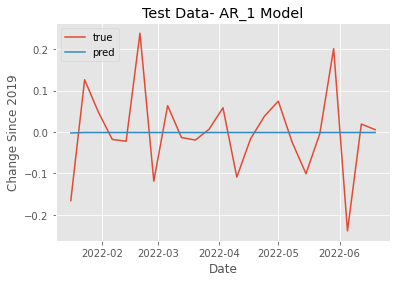

In [144]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(DAL_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## New Orleans Modeling

In [145]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
NOLA_train = NOLA_new[:cutoff]
NOLA_test = NOLA_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


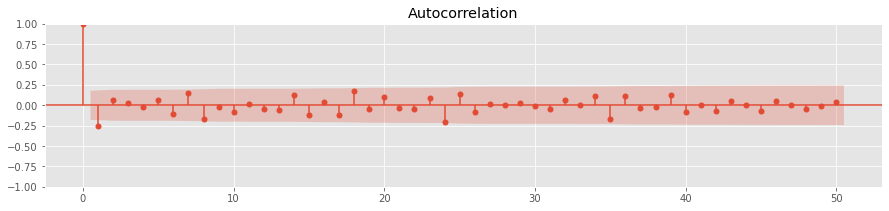

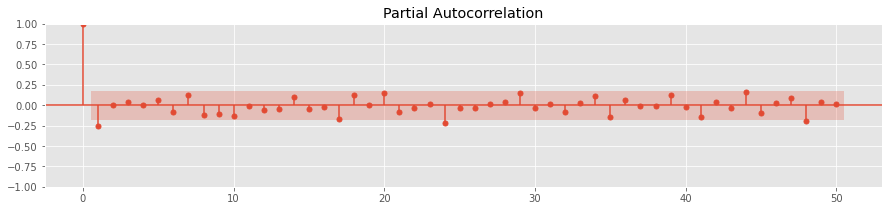

In [146]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(NOLA_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(NOLA_new, ax=ax, lags=50);

In [147]:
#Baseline Model

NOLA_naive = NOLA_train.shift(1).dropna()
NOLA_naive.head()

2020-03-08   -0.28
2020-03-15    0.13
2020-03-22   -0.25
2020-03-29   -0.72
2020-04-05    0.00
Freq: W-SUN, Name: New Orleans, dtype: float64

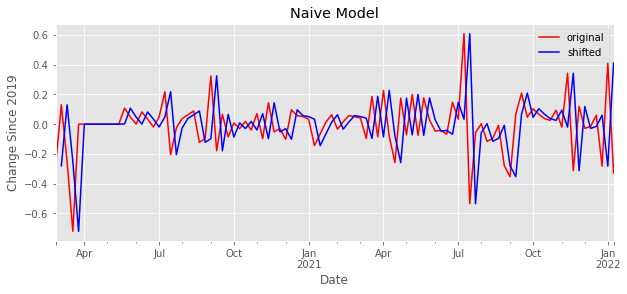

In [148]:
fig, ax = plt.subplots(figsize=(10, 4))

NOLA_train[0:200].plot(ax=ax, c='r', label='original')
NOLA_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [149]:
NOLA_naive_rmse = np.sqrt(mean_squared_error(NOLA_train[1:], NOLA_naive.dropna()))
NOLA_naive_rmse

0.27290152787686217

In [150]:
#First standard ARIMA model 
NOLA_AR_1 = ARIMA(NOLA_train, order=(0, 0, 1)).fit()  
print(NOLA_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:            New Orleans   No. Observations:                   98
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  35.640
Date:                Thu, 07 Jul 2022   AIC                            -65.279
Time:                        18:48:35   BIC                            -57.524
Sample:                    03-01-2020   HQIC                           -62.143
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.013     -0.295      0.768      -0.030       0.022
ma.L1         -0.2348      0.074     -3.188      0.001      -0.379      -0.090
sigma2         0.0283      0.002     12.373      0.0

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [151]:
train_preds_1 = NOLA_AR_1.predict(typ='levels')
test_preds_1 = NOLA_AR_1.predict(start=NOLA_test.index[0], end=NOLA_test.index[-1],typ='levels')

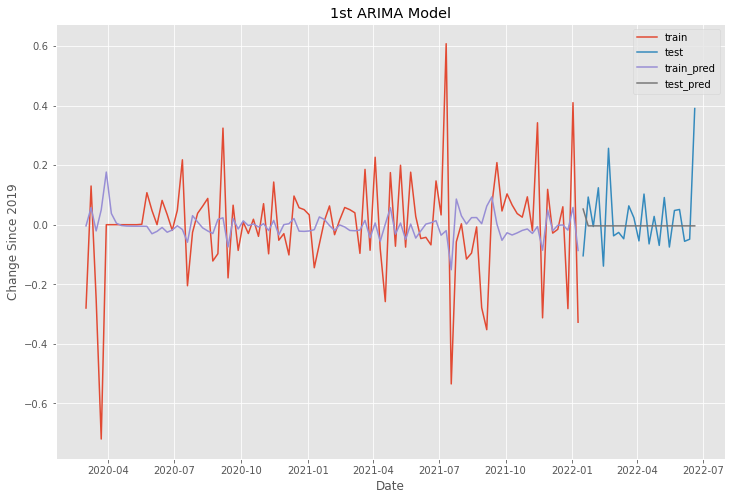

In [152]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

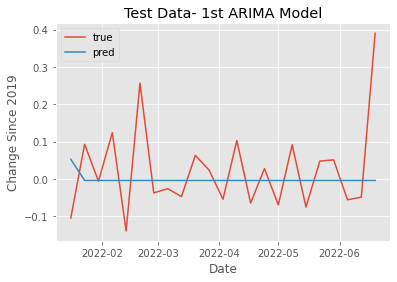

In [153]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [154]:
NOLA_AR_1_RMSE = np.sqrt(mean_squared_error(NOLA_test, test_preds_1))
NOLA_AR_1_RMSE

0.12305166297648397

In [155]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(NOLA_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-66.153, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-63.107, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-68.063, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-67.187, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-66.180, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-64.238, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-66.148, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.192 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  36.032
Date:                Thu, 07 Jul 2022   AIC                            -68.063
Time:                        18:48:35   BIC                            -62.893
Sample:                       

In [156]:
#2nd ARIMA model given the autocorrelation graph above 
NOLA_AR_2 = ARIMA(NOLA_train, order=(1,0,0)).fit()  
print(NOLA_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:            New Orleans   No. Observations:                   98
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  36.074
Date:                Thu, 07 Jul 2022   AIC                            -66.148
Time:                        18:48:35   BIC                            -58.393
Sample:                    03-01-2020   HQIC                           -63.011
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.014     -0.277      0.782      -0.031       0.024
ar.L1         -0.2687      0.075     -3.599      0.000      -0.415      -0.122
sigma2         0.0280      0.002     12.519      0.0

In [157]:
train_preds_2 = NOLA_AR_2.predict(typ='levels')
test_preds_2 = NOLA_AR_2.predict(start=NOLA_test.index[0], end=NOLA_test.index[-1],typ='levels')

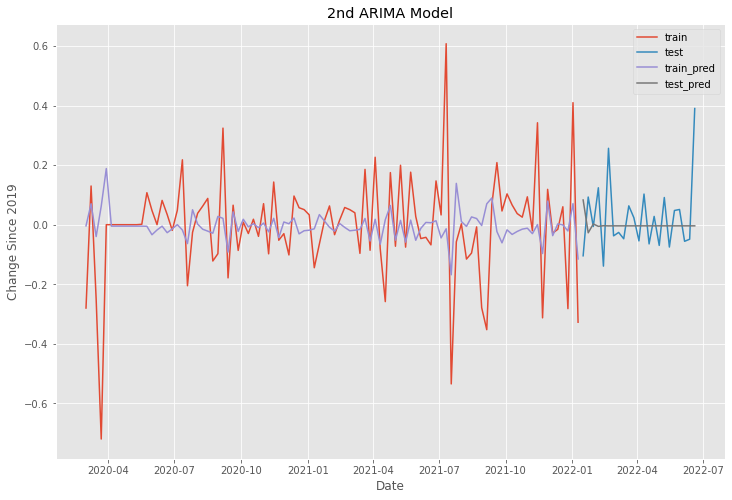

In [158]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

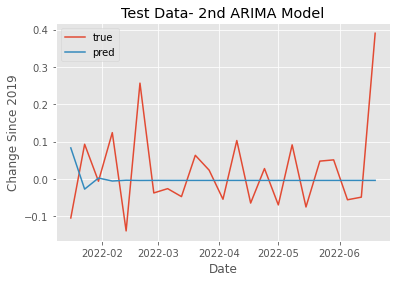

In [159]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [160]:
NOLA_AR_2_RMSE = np.sqrt(mean_squared_error(NOLA_test, test_preds_2))
NOLA_AR_2_RMSE

0.12587333542850654

In [161]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(NOLA_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-68.748, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-61.194, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-68.215, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-69.691, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-63.107, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-65.279, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[8] intercept   : AIC=-71.144, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[8] intercept   : AIC=-67.606, Time=0.06 sec
 ARIMA(0,0,1)(2,0,1)[8] intercept   : AIC=-69.180, Time=0.28 sec
 ARIMA(0,0,1)(1,0,2)[8] intercept   : AIC=-69.161, Time=0.31 sec
 ARIMA(0,0,1)(0,0,2)[8] intercept   : AIC=-70.058, Time=0.15 sec
 ARIMA(0,0,1)(2,0,0)[8] intercept   : AIC=-66.157, Time=0.12 sec
 ARIMA(0,0,1)(2,0,2)[8] intercept   : AIC=-67.927, Time=0.50 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-64.802, Time=0.16 sec
 ARIMA(1,0,1)(1,0,1)[8] intercept   : AIC=-71.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 8)   Log Likelihood                  41.565
Date:                             Thu, 07 Jul 2022   AIC                            -75.130
Time:                                     18:48:44   BIC                            -64.790
Sample:                                          0   HQIC                           -70.948
                                              - 98                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3355      0.080     -4.194      0.000      -0.492      -0.179
ar.S.L8        0.4415      0.229      1.928      0.054      -0.007       0.890
ma.S.L8       -0.8134      0.186     -4.383      0.000      -1.177      -0.450
sigma2         0.0242      0.002     13.542      0.000       0.021       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               194.82
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.14
Prob(H) (two-sided):                  0.53   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
NOLA_SARIMA =SARIMAX(NOLA_train,
                  order=(1,0,0),
                  seasonal_order=(1,0,1,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(NOLA_SARIMA.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         New Orleans   No. Observations:                   98
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 8)   Log Likelihood                  47.216
Date:                             Thu, 07 Jul 2022   AIC                            -86.433
Time:                                     18:48:44   BIC                            -76.478
Sample:                                 03-01-2020   HQIC                           -82.421
                                      - 01-09-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.084     -4.906      0.000      -0.579      -0.248
ar.S.L8       -0.0672      

In [163]:
train_preds_3 = NOLA_SARIMA.predict(typ='levels')
test_preds_3 = NOLA_SARIMA.predict(start=NOLA_test.index[0], end=NOLA_test.index[-1],typ='levels')

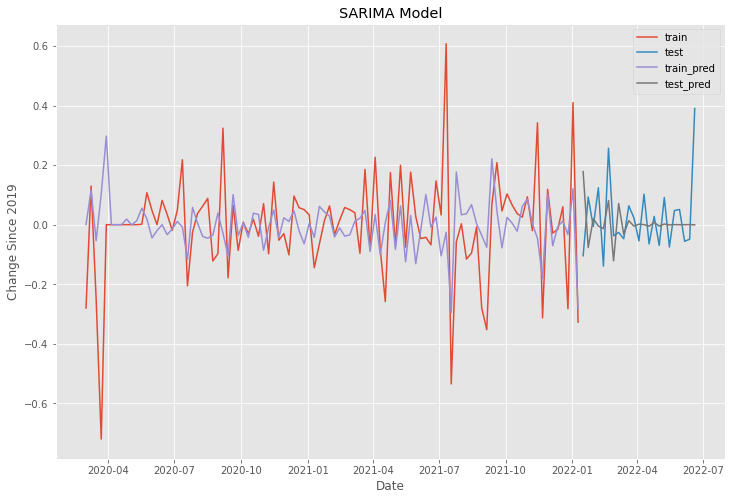

In [164]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

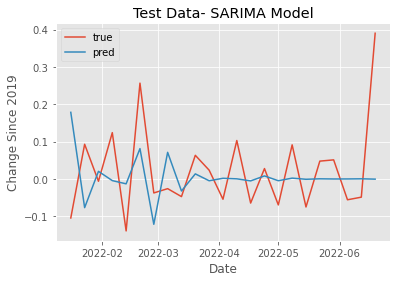

In [165]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [166]:
NOLA_SARIMA_RMSE = np.sqrt(mean_squared_error(NOLA_test, test_preds_3))
NOLA_SARIMA_RMSE

0.13039194870349088

In [167]:
#compiled test scores

In [168]:
print(f'AR_1 AIC: {NOLA_AR_1.aic}' )
print(f'AR_2 AIC: {NOLA_AR_2.aic}' )
print(f'SMODEL AIC: {NOLA_SARIMA.aic}' )

AR_1 AIC: -65.2793849056976
AR_2 AIC: -66.14787052584775
SMODEL AIC: -86.43299855361074


In [169]:
print(f'Naive RMSE: {NOLA_naive_rmse}')
print(f'AR_1 RMSE: {NOLA_AR_1_RMSE}' )
print(f'AR_2 RMSE: {NOLA_AR_2_RMSE}' )
print(f'SMODEL RMSE: {NOLA_SARIMA_RMSE}' )

Naive RMSE: 0.27290152787686217
AR_1 RMSE: 0.12305166297648397
AR_2 RMSE: 0.12587333542850654
SMODEL RMSE: 0.13039194870349088


In [170]:
#final model- AR_1

Even though the SMODEL had the highest AIC, I chose to use AR_1 as my final model because it had a lower RMSE

In [171]:
#Forecast Error
forecast_error = (NOLA_test- test_preds_1)
forecast_error

2022-01-16   -0.16
2022-01-23    0.10
2022-01-30   -0.00
2022-02-06    0.13
2022-02-13   -0.14
2022-02-20    0.26
2022-02-27   -0.03
2022-03-06   -0.02
2022-03-13   -0.04
2022-03-20    0.07
2022-03-27    0.03
2022-04-03   -0.05
2022-04-10    0.11
2022-04-17   -0.06
2022-04-24    0.03
2022-05-01   -0.07
2022-05-08    0.10
2022-05-15   -0.07
2022-05-22    0.05
2022-05-29    0.06
2022-06-05   -0.05
2022-06-12   -0.04
2022-06-19    0.39
Freq: W-SUN, dtype: float64

In [172]:
#Mean Forecast Error
mean_forecast_error = (NOLA_test - test_preds_1).mean()
mean_forecast_error

0.02508335904442183

In [173]:
df_forecast=pd.concat([NOLA_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-16      -0.10            0.05       -0.16
2022-01-23       0.09           -0.00        0.10
2022-01-30      -0.01           -0.00       -0.00
2022-02-06       0.12           -0.00        0.13
2022-02-13      -0.14           -0.00       -0.14
2022-02-20       0.26           -0.00        0.26
2022-02-27      -0.04           -0.00       -0.03
2022-03-06      -0.03           -0.00       -0.02
2022-03-13      -0.05           -0.00       -0.04
2022-03-20       0.06           -0.00        0.07
2022-03-27       0.02           -0.00        0.03
2022-04-03      -0.05           -0.00       -0.05
2022-04-10       0.10           -0.00        0.11
2022-04-17      -0.06           -0.00       -0.06
2022-04-24       0.03           -0.00        0.03
2022-05-01      -0.07           -0.00       -0.07
2022-05-08       0.09           -0.00        0.10
2022-05-15      -0.08           -0.00       -0.07
2022-05-22       0.05           -0.00        0.05
2022-05-29       0.05           -0.00        0.06
2022-06-05      -0.06           -0.00       -0.05
2022-06-12      -0.05           -0.00       -0.04
2022-06-19       0.39           -0.00        0.39

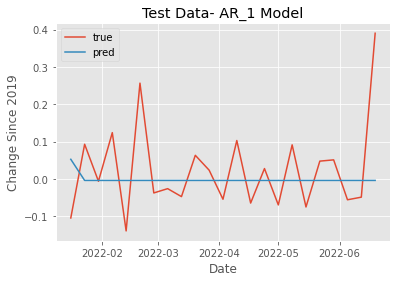

In [174]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(NOLA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## Miami Forecasting

In [175]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
MIA_train = MIA_new[:cutoff]
MIA_test = MIA_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


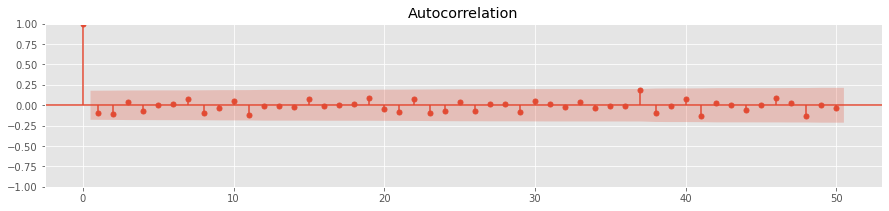

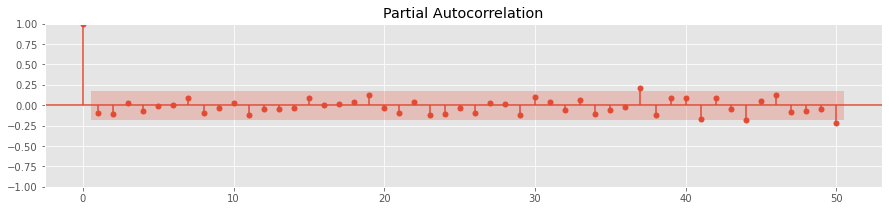

In [176]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(MIA_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(MIA_new, ax=ax, lags=50);

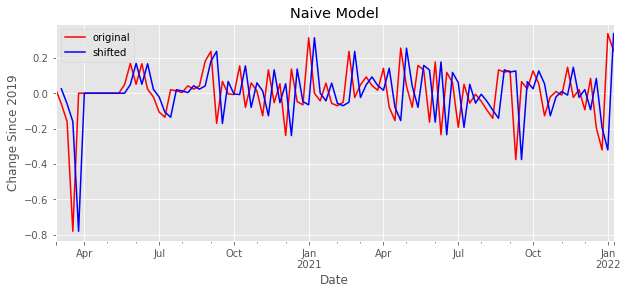

In [177]:
#Baseline Model
MIA_naive = MIA_train.shift(1).dropna()
MIA_naive.head()

fig, ax = plt.subplots(figsize=(10, 4))

MIA_train[0:200].plot(ax=ax, c='r', label='original')
MIA_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [178]:
MIA_naive_rmse = np.sqrt(mean_squared_error(MIA_train[1:], MIA_naive.dropna()))
MIA_naive_rmse

0.21530107689312705

In [179]:
#First standard ARIMA model 
MIA_AR_1 = ARIMA(MIA_train, order=(0, 0, 1)).fit()  
print(MIA_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Miami   No. Observations:                   98
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  48.533
Date:                Thu, 07 Jul 2022   AIC                            -91.066
Time:                        18:48:45   BIC                            -83.311
Sample:                    03-01-2020   HQIC                           -87.929
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.016      0.202      0.840      -0.029       0.035
ma.L1         -0.0759      0.102     -0.743      0.457      -0.276       0.124
sigma2         0.0217      0.002     12.113      0.0

In [180]:
train_preds_1 = MIA_AR_1.predict(typ='levels')
test_preds_1 = MIA_AR_1.predict(start=MIA_test.index[0], end=MIA_test.index[-1],typ='levels')

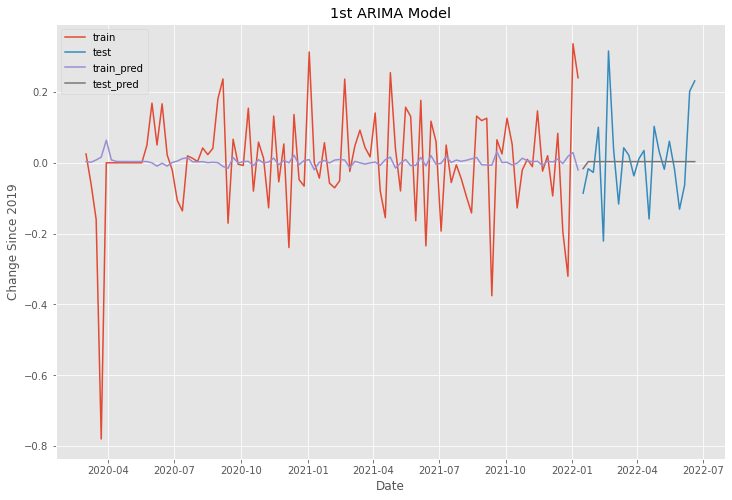

In [181]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

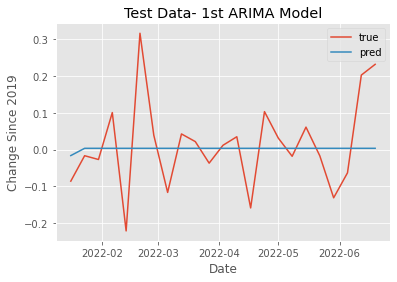

In [182]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [183]:
MIA_AR_1_RMSE = np.sqrt(mean_squared_error(MIA_test, test_preds_1))
MIA_AR_1_RMSE

0.12135384277111658

In [184]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(MIA_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-91.710, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-94.541, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-92.936, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-93.009, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-92.596, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.156 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  48.270
Date:                Thu, 07 Jul 2022   AIC                            -94.541
Time:                        18:48:45   BIC                            -91.956
Sample:                             0   HQIC                           -93.495
                                 - 98                                         
Co

In [185]:
#2nd ARIMA model given the autocorrelation graph above 
MIA_AR_2 = ARIMA(MIA_train, order=(0,0,0)).fit()  
print(MIA_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Miami   No. Observations:                   98
Model:                          ARIMA   Log Likelihood                  48.298
Date:                Thu, 07 Jul 2022   AIC                            -92.596
Time:                        18:48:45   BIC                            -87.426
Sample:                    03-01-2020   HQIC                           -90.505
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.017      0.202      0.840      -0.030       0.037
sigma2         0.0218      0.002     12.781      0.000       0.018       0.025
Ljung-Box (L1) (Q):                   0.40   Jarque-

In [186]:
train_preds_2 = MIA_AR_2.predict(typ='levels')
test_preds_2 = MIA_AR_2.predict(start=MIA_test.index[0], end=MIA_test.index[-1],typ='levels')

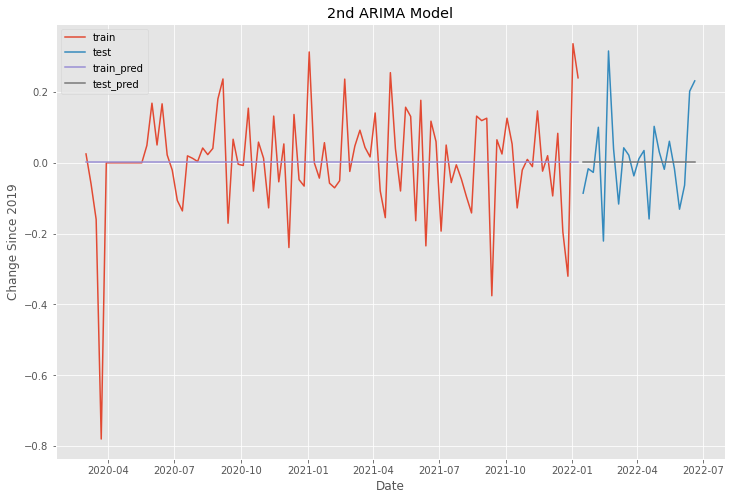

In [187]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

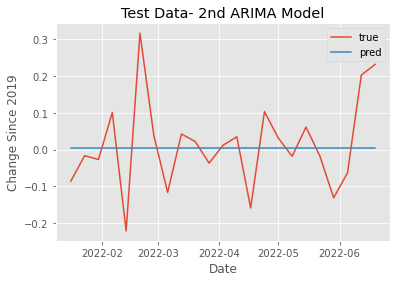

In [188]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [189]:
MIA_AR_2_RMSE = np.sqrt(mean_squared_error(MIA_test, test_preds_2))
MIA_AR_2_RMSE

0.12189666813078032

In [190]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(MIA_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-92.596, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-89.360, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-89.548, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-94.541, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[8] intercept   : AIC=-90.963, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[8] intercept   : AIC=-91.093, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-90.520, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-90.993, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-91.066, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[8]          
Total fit time: 0.550 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  48.270
Date:                Thu, 07 Jul 2022   AIC                            -94.541
Time:                        18:48:46   BIC                            -91.956
Sample:                             0   HQIC                           -93.495
                                 - 98                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0219      0.001     14.672      0.000       0.019       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               233.59
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -1.51
Prob(H) (two-sided):                  0.74   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [191]:
MIA_SARIMA =SARIMAX(MIA_train,
                  order=(0,0,0),
                  seasonal_order=(1,0,1,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(MIA_SARIMA.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     Miami   No. Observations:                   98
Model:             SARIMAX(1, 0, [1], 8)   Log Likelihood                  55.784
Date:                   Thu, 07 Jul 2022   AIC                           -105.568
Time:                           18:48:46   BIC                            -98.102
Sample:                       03-01-2020   HQIC                          -102.559
                            - 01-09-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L8        0.0652      0.300      0.218      0.828      -0.522       0.652
ma.S.L8       -0.2218      0.301     -0.738      0.461      -0.811       0.367
sigma2         0.0166      0

In [192]:
train_preds_3 = MIA_SARIMA.predict(typ='levels')
test_preds_3 = MIA_SARIMA.predict(start=MIA_test.index[0], end=MIA_test.index[-1],typ='levels')

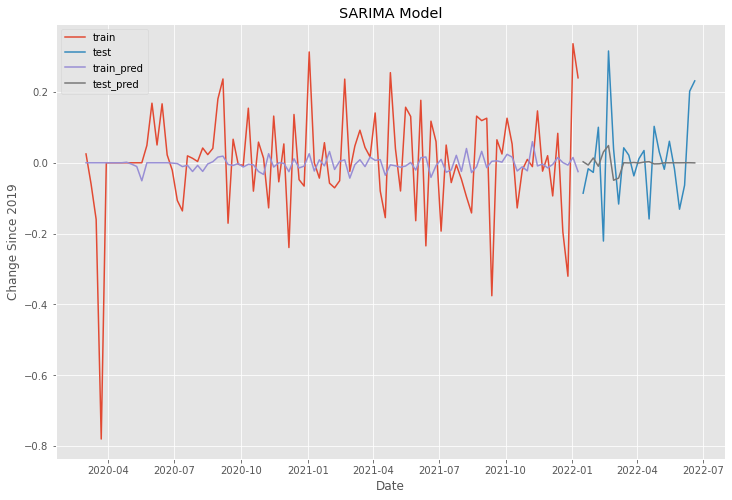

In [193]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

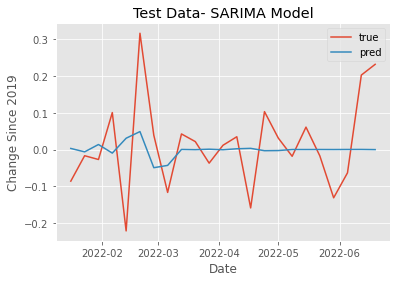

In [194]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [195]:
MIA_SARIMA_RMSE = np.sqrt(mean_squared_error(MIA_test, test_preds_3))
MIA_SARIMA_RMSE

0.12031105051032988

In [196]:
#compiled test scores

In [197]:
print(f'AR_1 AIC: {MIA_AR_1.aic}' )
print(f'AR_2 AIC: {MIA_AR_2.aic}' )
print(f'SMODEL AIC: {MIA_SARIMA.aic}' )

AR_1 AIC: -91.06570717938231
AR_2 AIC: -92.59575373839613
SMODEL AIC: -105.56790352469923


In [198]:
print(f'Naive RMSE: {MIA_naive_rmse}')
print(f'AR_1 RMSE: {MIA_AR_1_RMSE}' )
print(f'AR_2 RMSE: {MIA_AR_2_RMSE}' )
print(f'SMODEL RMSE: {MIA_SARIMA_RMSE}' )

Naive RMSE: 0.21530107689312705
AR_1 RMSE: 0.12135384277111658
AR_2 RMSE: 0.12189666813078032
SMODEL RMSE: 0.12031105051032988


In [199]:
#final model- SARIMA

In [200]:
#Forecast Error
forecast_error = (MIA_test- test_preds_3)
forecast_error

2022-01-16   -0.09
2022-01-23   -0.01
2022-01-30   -0.04
2022-02-06    0.11
2022-02-13   -0.25
2022-02-20    0.27
2022-02-27    0.09
2022-03-06   -0.07
2022-03-13    0.04
2022-03-20    0.02
2022-03-27   -0.04
2022-04-03    0.01
2022-04-10    0.03
2022-04-17   -0.16
2022-04-24    0.11
2022-05-01    0.03
2022-05-08   -0.02
2022-05-15    0.06
2022-05-22   -0.02
2022-05-29   -0.13
2022-06-05   -0.06
2022-06-12    0.20
2022-06-19    0.23
Freq: W-SUN, dtype: float64

In [201]:
#Mean Forecast Error
mean_forecast_error = (MIA_test - test_preds_3).mean()
mean_forecast_error

0.01362230476780385

In [202]:
df_forecast=pd.concat([MIA_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-16      -0.09           -0.02       -0.09
2022-01-23      -0.02            0.00       -0.01
2022-01-30      -0.03            0.00       -0.04
2022-02-06       0.10            0.00        0.11
2022-02-13      -0.22            0.00       -0.25
2022-02-20       0.32            0.00        0.27
2022-02-27       0.04            0.00        0.09
2022-03-06      -0.12            0.00       -0.07
2022-03-13       0.04            0.00        0.04
2022-03-20       0.02            0.00        0.02
2022-03-27      -0.04            0.00       -0.04
2022-04-03       0.01            0.00        0.01
2022-04-10       0.03            0.00        0.03
2022-04-17      -0.16            0.00       -0.16
2022-04-24       0.10            0.00        0.11
2022-05-01       0.03            0.00        0.03
2022-05-08      -0.02            0.00       -0.02
2022-05-15       0.06            0.00        0.06
2022-05-22      -0.02            0.00       -0.02
2022-05-29      -0.13            0.00       -0.13
2022-06-05      -0.06            0.00       -0.06
2022-06-12       0.20            0.00        0.20
2022-06-19       0.23            0.00        0.23

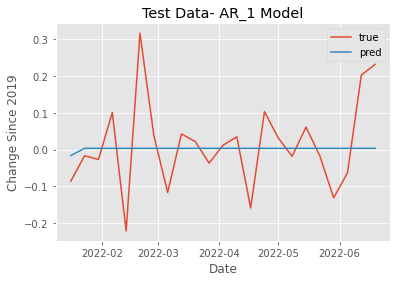

In [203]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(MIA_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## Phoenix Modeling

In [204]:
# Define train and test sets according to the index cutoff
# using the same index cutoff as NY because all cities have the same number of rows
PHO_train = PHO_new[:cutoff]
PHO_test = PHO_new[cutoff:]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


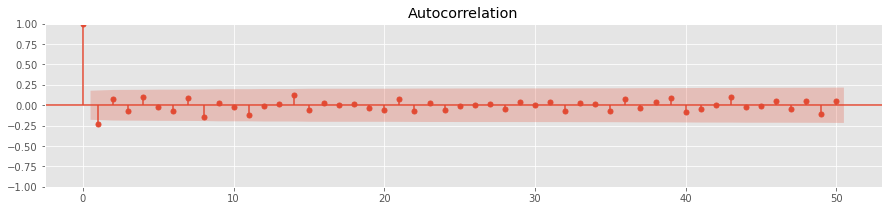

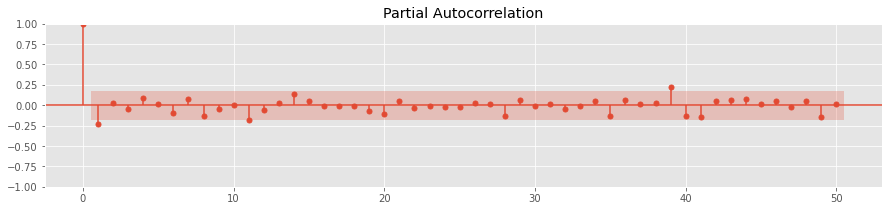

In [205]:
#look at autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(PHO_new, ax=ax, lags=50);

fig, ax = plt.subplots(figsize=(15,3))
plot_pacf(PHO_new, ax=ax, lags=50);

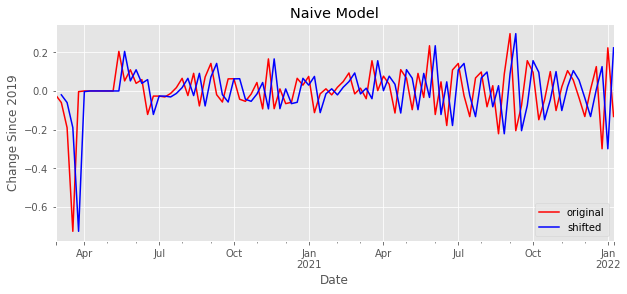

In [206]:
#Baseline Model
PHO_naive = PHO_train.shift(1).dropna()
PHO_naive.head()

fig, ax = plt.subplots(figsize=(10, 4))

PHO_train[0:200].plot(ax=ax, c='r', label='original')
PHO_naive[0:200].plot(ax=ax, c='b', label='shifted')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Naive Model')
ax.legend();

In [207]:
PHO_naive_rmse = np.sqrt(mean_squared_error(PHO_train[1:], PHO_naive.dropna()))
PHO_naive_rmse

0.1861881179284327

In [208]:
#First standard ARIMA model 
PHO_AR_1 = ARIMA(PHO_train, order=(0, 0, 1)).fit()  
print(PHO_AR_1.summary())

                               SARIMAX Results                                
Dep. Variable:                Phoenix   No. Observations:                   98
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  65.208
Date:                Thu, 07 Jul 2022   AIC                           -124.416
Time:                        18:48:47   BIC                           -116.661
Sample:                    03-01-2020   HQIC                          -121.279
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.014     -0.068      0.946      -0.028       0.026
ma.L1         -0.1099      0.111     -0.987      0.324      -0.328       0.108
sigma2         0.0155      0.001     11.676      0.0

In [209]:
train_preds_1 = PHO_AR_1.predict(typ='levels')
test_preds_1 = PHO_AR_1.predict(start=PHO_test.index[0], end=PHO_test.index[-1],typ='levels')

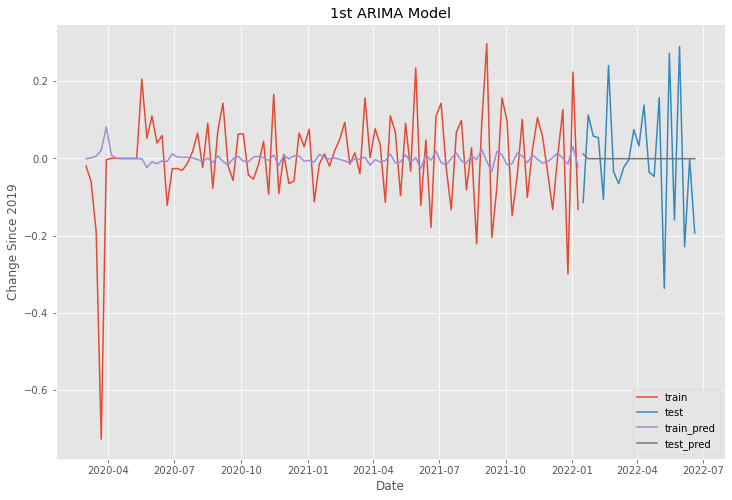

In [210]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
ax.plot(train_preds_1, label='train_pred')
ax.plot(test_preds_1, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('1st ARIMA Model')
plt.legend();

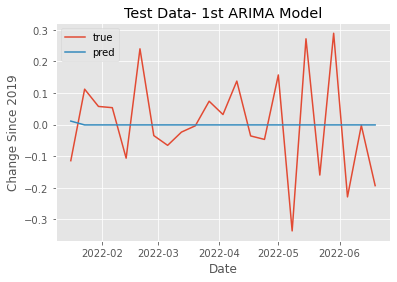

In [211]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 1st ARIMA Model')

plt.legend();

In [212]:
PHO_AR_1_RMSE = np.sqrt(mean_squared_error(PHO_test, test_preds_1))
PHO_AR_1_RMSE

0.15461155562084794

In [213]:
#Use auto_model tool to find the optimal ARIMA model 

auto_model = pm.auto_arima(PHO_train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=10, max_q=10,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-124.449, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-127.297, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-126.324, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-126.409, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-125.304, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.103 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  64.648
Date:                Thu, 07 Jul 2022   AIC                           -127.297
Time:                        18:48:47   BIC                           -124.712
Sample:                             0   HQIC                          -126.251
                                 - 98                                       

In [214]:
#2nd ARIMA model given the autocorrelation graph above 
PHO_AR_2 = ARIMA(PHO_train, order=(0,0,0)).fit()  
print(PHO_AR_2.summary())

                               SARIMAX Results                                
Dep. Variable:                Phoenix   No. Observations:                   98
Model:                          ARIMA   Log Likelihood                  64.652
Date:                Thu, 07 Jul 2022   AIC                           -125.304
Time:                        18:48:47   BIC                           -120.134
Sample:                    03-01-2020   HQIC                          -123.213
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.015     -0.071      0.943      -0.031       0.029
sigma2         0.0156      0.001     14.353      0.000       0.014       0.018
Ljung-Box (L1) (Q):                   1.05   Jarque-

In [215]:
train_preds_2 = PHO_AR_2.predict(typ='levels')
test_preds_2 = PHO_AR_2.predict(start=PHO_test.index[0], end=PHO_test.index[-1],typ='levels')

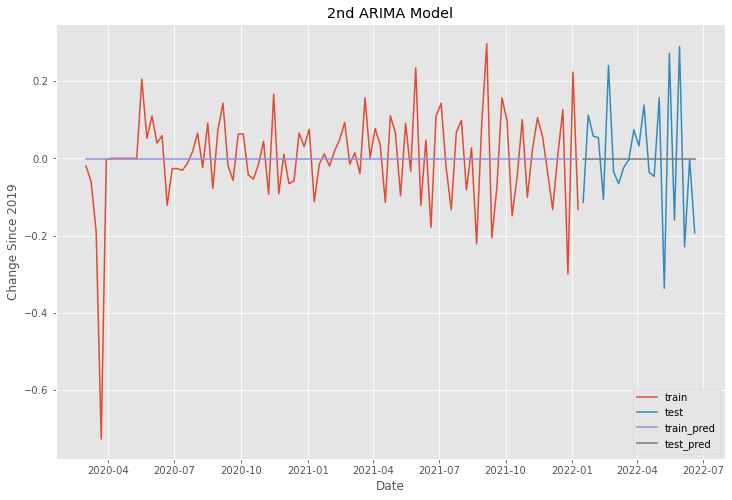

In [216]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
ax.plot(train_preds_2, label='train_pred')
ax.plot(test_preds_2, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('2nd ARIMA Model')

plt.legend();

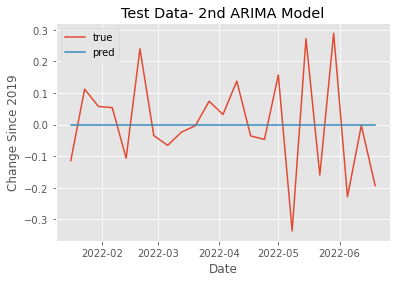

In [217]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_2, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- 2nd ARIMA Model')

plt.legend();

In [218]:
PHO_AR_2_RMSE = np.sqrt(mean_squared_error(PHO_test, test_preds_2))
PHO_AR_2_RMSE

0.15420941111040481

In [219]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(PHO_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=8,
                         start_P=0, seasonal=True,
                         d=0, trace=True, stationary = True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[8] intercept   : AIC=-122.418, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=-125.304, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=-124.091, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=-124.247, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[8]             : AIC=-127.297, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[8] intercept   : AIC=-125.030, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[8] intercept   : AIC=-125.051, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[8] intercept   : AIC=-123.030, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=-124.330, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[8] intercept   : AIC=-124.416, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[8] intercept   : AIC=-122.455, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[8]          
Total fit time: 0.521 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  64.648
Date:                Thu, 07 Jul 2022   AIC                           -127.297
Time:                        18:48:48   BIC                           -124.712
Sample:                             0   HQIC                          -126.251
                                 - 98                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0157      0.001     17.240      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):               473.63
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.91
Prob(H) (two-sided):                  0.83   Kurtosis:                        13.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
PHO_SARIMA =SARIMAX(PHO_train,
                  order=(0,0,0),
                  seasonal_order=(0,0,0,8),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
print(PHO_SARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                Phoenix   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                  63.504
Date:                Thu, 07 Jul 2022   AIC                           -125.008
Time:                        18:48:48   BIC                           -122.433
Sample:                    03-01-2020   HQIC                          -123.967
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0158      0.001     17.062      0.000       0.014       0.018
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):               459.18
Prob(Q):                              0.30   Pr

In [221]:
train_preds_3 = PHO_SARIMA.predict(typ='levels')
test_preds_3 = PHO_SARIMA.predict(start=PHO_test.index[0], end=PHO_test.index[-1],typ='levels')

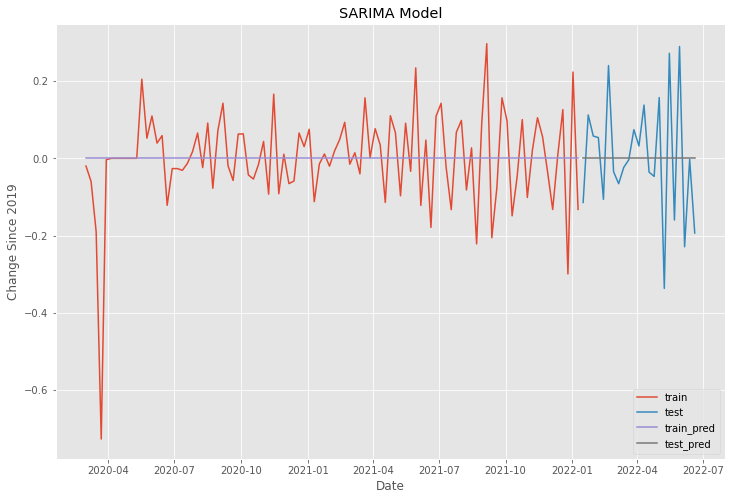

In [222]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
ax.plot(train_preds_3, label='train_pred')
ax.plot(test_preds_3, label='test_pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('SARIMA Model')

plt.legend();

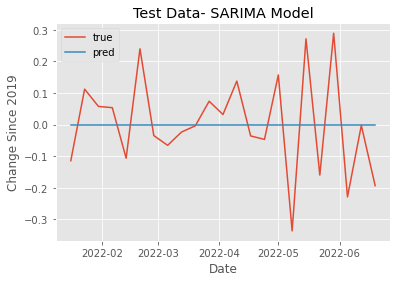

In [223]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_3, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- SARIMA Model')

plt.legend();

In [224]:
PHO_SARIMA_RMSE = np.sqrt(mean_squared_error(PHO_test, test_preds_3))
PHO_SARIMA_RMSE

0.15418280792899566

In [225]:
#compiled test scores

In [226]:
print(f'AR_1 AIC: {PHO_AR_1.aic}' )
print(f'AR_2 AIC: {PHO_AR_2.aic}' )
print(f'SMODEL AIC: {PHO_SARIMA.aic}' )

AR_1 AIC: -124.41552074970522
AR_2 AIC: -125.3041703706761
SMODEL AIC: -125.00797734289371


In [227]:
print(f'Naive RMSE: {PHO_naive_rmse}')
print(f'AR_1 RMSE: {PHO_AR_1_RMSE}' )
print(f'AR_2 RMSE: {PHO_AR_2_RMSE}' )
print(f'SMODEL RMSE: {PHO_SARIMA_RMSE}' )

Naive RMSE: 0.1861881179284327
AR_1 RMSE: 0.15461155562084794
AR_2 RMSE: 0.15420941111040481
SMODEL RMSE: 0.15418280792899566


In [228]:
#final model- SARIMA

In [229]:
#Forecast Error
forecast_error = (PHO_test- test_preds_3)
forecast_error

2022-01-16   -0.11
2022-01-23    0.11
2022-01-30    0.06
2022-02-06    0.05
2022-02-13   -0.11
2022-02-20    0.24
2022-02-27   -0.03
2022-03-06   -0.07
2022-03-13   -0.02
2022-03-20   -0.00
2022-03-27    0.07
2022-04-03    0.03
2022-04-10    0.14
2022-04-17   -0.04
2022-04-24   -0.05
2022-05-01    0.16
2022-05-08   -0.34
2022-05-15    0.27
2022-05-22   -0.16
2022-05-29    0.29
2022-06-05   -0.23
2022-06-12   -0.00
2022-06-19   -0.19
Freq: W-SUN, dtype: float64

In [230]:
#Mean Forecast Error
mean_forecast_error = (PHO_test - test_preds_3).mean()
mean_forecast_error

0.0032521739130434786

In [231]:
df_forecast=pd.concat([PHO_test, test_preds_1, forecast_error],axis=1)
df_forecast.columns = ['True Test', 'Predicted Test', 'Difference']
df_forecast

True Test  Predicted Test  Difference
2022-01-16      -0.11            0.01       -0.11
2022-01-23       0.11           -0.00        0.11
2022-01-30       0.06           -0.00        0.06
2022-02-06       0.05           -0.00        0.05
2022-02-13      -0.11           -0.00       -0.11
2022-02-20       0.24           -0.00        0.24
2022-02-27      -0.03           -0.00       -0.03
2022-03-06      -0.07           -0.00       -0.07
2022-03-13      -0.02           -0.00       -0.02
2022-03-20      -0.00           -0.00       -0.00
2022-03-27       0.07           -0.00        0.07
2022-04-03       0.03           -0.00        0.03
2022-04-10       0.14           -0.00        0.14
2022-04-17      -0.04           -0.00       -0.04
2022-04-24      -0.05           -0.00       -0.05
2022-05-01       0.16           -0.00        0.16
2022-05-08      -0.34           -0.00       -0.34
2022-05-15       0.27           -0.00        0.27
2022-05-22      -0.16           -0.00       -0.16
2022-05-29       0.29           -0.00        0.29
2022-06-05      -0.23           -0.00       -0.23
2022-06-12      -0.00           -0.00       -0.00
2022-06-19      -0.19           -0.00       -0.19

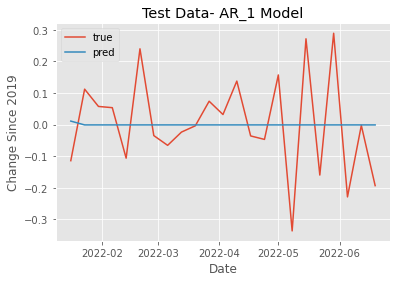

In [232]:
# Zoomed in on test data
fig, ax = plt.subplots()

ax.plot(PHO_test, label='true')
ax.plot(test_preds_1, label='pred')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('Test Data- AR_1 Model')

plt.legend();

## Appendix

### LA Train/Test Split

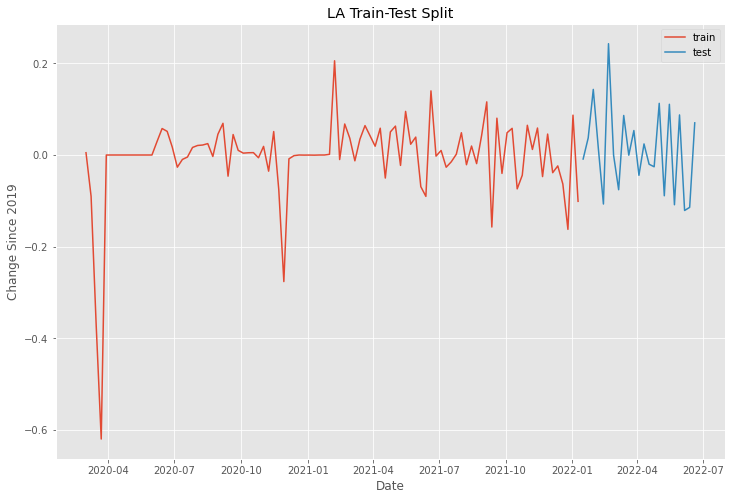

In [233]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(LA_train, label='train')
ax.plot(LA_test, label='test')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('LA Train-Test Split')
plt.legend();

### DAL Train/Test Split

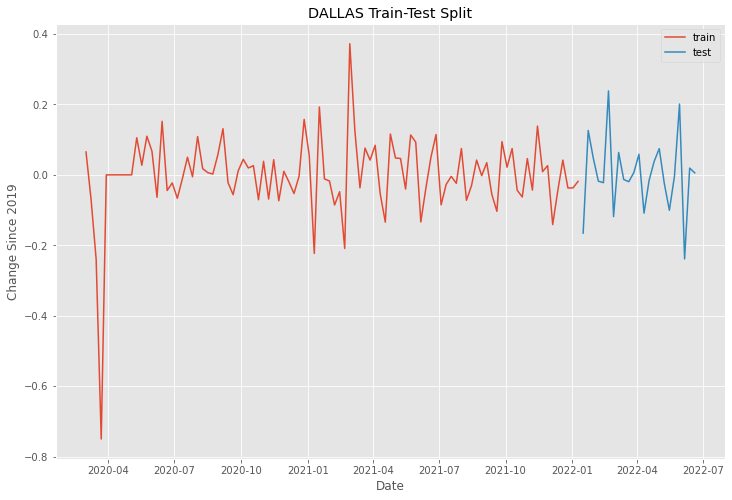

In [234]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(DAL_train, label='train')
ax.plot(DAL_test, label='test')

plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('DALLAS Train-Test Split')
plt.legend();

### NOLA Train/Test Split

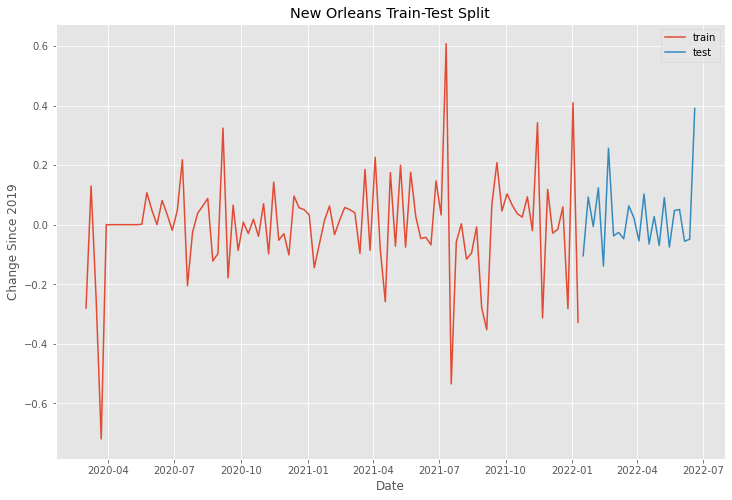

In [235]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(NOLA_train, label='train')
ax.plot(NOLA_test, label='test')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('New Orleans Train-Test Split')
plt.legend();

### MIA Train/Test Split

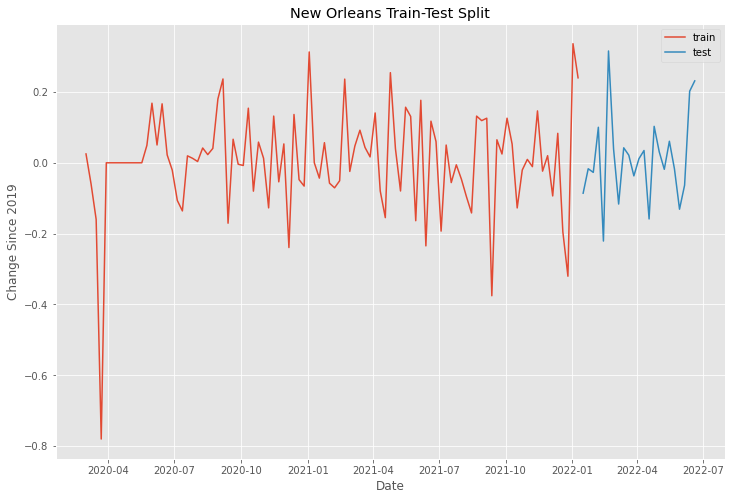

In [236]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(MIA_train, label='train')
ax.plot(MIA_test, label='test')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('New Orleans Train-Test Split')
plt.legend();

### PHO Train/Test Split

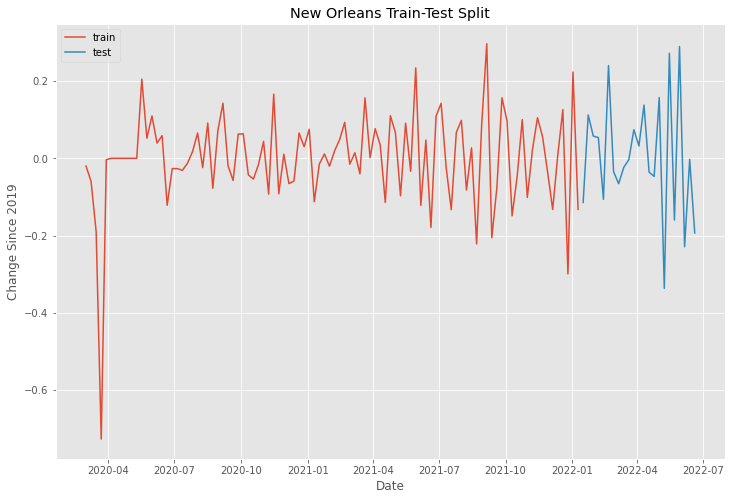

In [237]:
#visualize the train/test split

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(PHO_train, label='train')
ax.plot(PHO_test, label='test')
plt.xlabel('Date')
plt.ylabel('Change Since 2019')
ax.set_title('New Orleans Train-Test Split')
plt.legend();